## Task_4 : Object Detection (Cows & Buffalos)

*   **Objective:** Build and evaluate object detection models to identify "Cows" and "Bulls" in images.
*   **Data Loading and Exploration:** Loaded the dataset, analyzed class distribution, bounding box sizes, and class co-occurrence.
*   **Data Preparation:** Filtered out low-occurrence classes, split the dataset, and applied data augmentation to address class imbalance.
*   **Model Training:** Trained different YOLO models (YOLOv8 variants, YOLOv5n, YOLOv10n) on the prepared dataset.
*   **Model Evaluation:** Evaluated the performance of each trained model using metrics like mAP on the test set.
*   **Model Comparison:** Compared the performance of the different YOLO variants to identify the best-performing model.
*   **Prediction:** Used the trained models to make predictions on new images.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from google.colab import drive
from collections import Counter
import random
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Loading and Initial Setup

This section involved mounting Google Drive to access the dataset and defining the paths to the image and label directories.

In [3]:
datadir = '/content/drive/MyDrive/archive (11)'
# Update the paths based on the file listing
images = os.path.join(datadir,'train','images') # Assuming images are in a 'train/images' subdirectory
labels = os.path.join(datadir,'train','labels') # Assuming labels are in a 'train/labels' subdirectory

In [4]:
image_files = [f for f in os.listdir(images) if f.endswith(('.jpg', '.png'))]
def read_labels(label_path):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file.readlines():
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            boxes.append({
                'class_id': int(class_id),
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
    return boxes

In [5]:
# Validate file counts
image_files = sorted([f for f in os.listdir(images) if f.endswith(('.jpg', '.png', '.jpeg'))])
label_files = sorted([f for f in os.listdir(labels) if f.endswith('.txt')])

print(f"Total images: {len(image_files)}")
print(f"Total label files: {len(label_files)}")

Total images: 1747
Total label files: 1747


## 2. Data Exploration (EDA)

In this stage, we explored the characteristics of the dataset through visualizations:
- **Class Distribution:** Analyzing the frequency of each object class.
- **Bounding Box Analysis:** Examining the distribution of bounding box sizes and aspect ratios.
- **Class Co-occurrence:** Understanding how often different classes appear together in images.
- **Visualizing Images with Bounding Boxes:** Inspecting sample images with their annotations.
- **Image Embedding Visualization:** Exploring the distribution of image features.

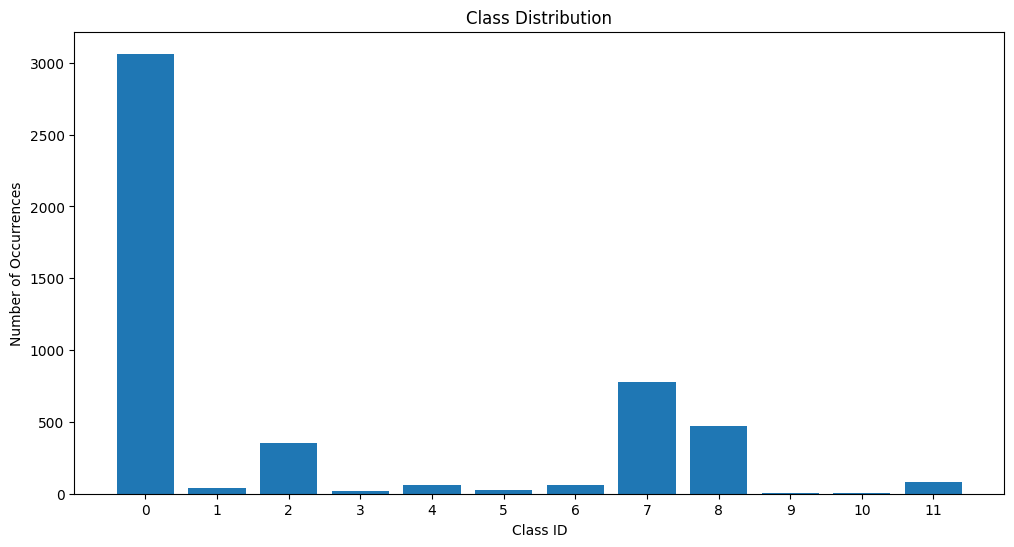

Class Distribution:
Class ID 0: 3063 occurrences
Class ID 1: 43 occurrences
Class ID 2: 352 occurrences
Class ID 3: 21 occurrences
Class ID 4: 61 occurrences
Class ID 5: 25 occurrences
Class ID 6: 63 occurrences
Class ID 7: 775 occurrences
Class ID 8: 471 occurrences
Class ID 9: 2 occurrences
Class ID 10: 2 occurrences
Class ID 11: 83 occurrences


In [6]:
import os
from collections import Counter
import matplotlib.pyplot as plt

dataset_path = '/content/drive/MyDrive/archive (11)'
labels_path = os.path.join(dataset_path, 'train', 'labels')

class_counts = Counter()

# Check if the labels directory exists
if not os.path.exists(labels_path):
    print(f"Error: Labels directory not found at {labels_path}")
else:
    # Iterate through each label file
    for filename in os.listdir(labels_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(labels_path, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    # YOLOv8 format: class_id center_x center_y width height
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1

    # Sort the class counts by class ID
    sorted_class_counts = dict(sorted(class_counts.items()))

    # Prepare data for plotting
    class_ids = list(sorted_class_counts.keys())
    counts = list(sorted_class_counts.values())

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(class_ids, counts)
    plt.xlabel('Class ID')
    plt.ylabel('Number of Occurrences')
    plt.title('Class Distribution')
    plt.xticks(class_ids)
    plt.show()

    print("Class Distribution:")
    for class_id, count in sorted_class_counts.items():
        print(f"Class ID {class_id}: {count} occurrences")

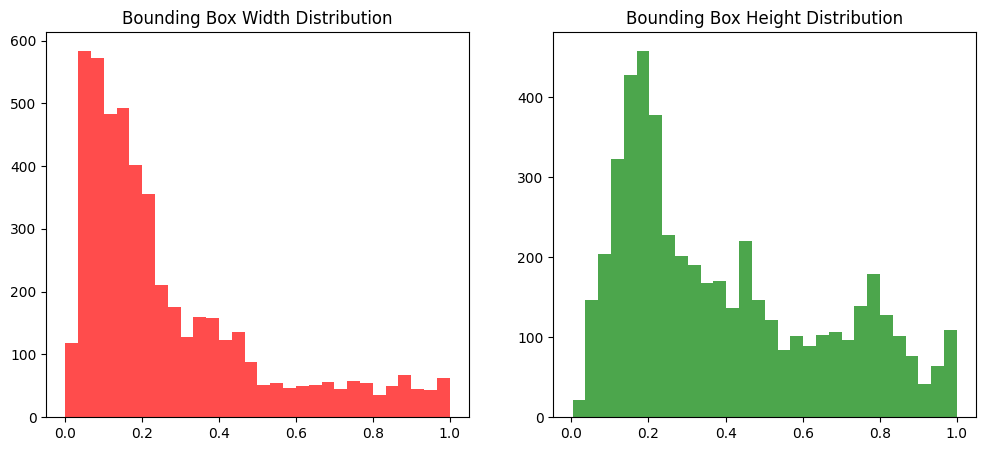

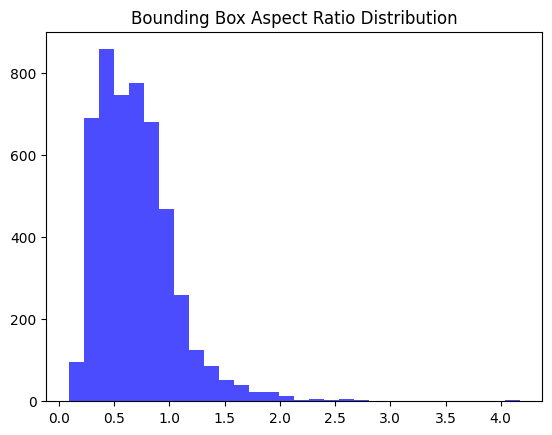

In [ ]:
widths, heights = [], []
labels_dir = '/content/drive/MyDrive/archive (11)/train/labels'

for label_file in os.listdir(labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                parts = line.split()
                w, h = float(parts[3]), float(parts[4])  # YOLO normalized width, height
                widths.append(w)
                heights.append(h)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='Red', alpha=0.7)
plt.title('Bounding Box Width Distribution')
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Bounding Box Height Distribution')
plt.show()

# Aspect ratio
ratios = [w / h if h !=0 else 0 for w, h in zip(widths, heights)]
plt.hist(ratios, bins=30, color='blue', alpha=0.7)
plt.title('Bounding Box Aspect Ratio Distribution')
plt.show()


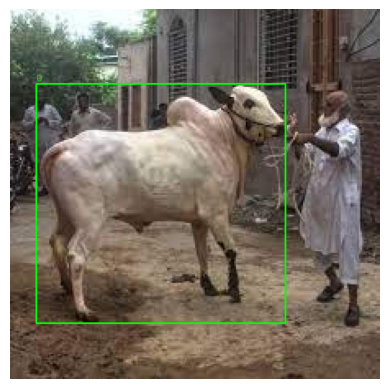

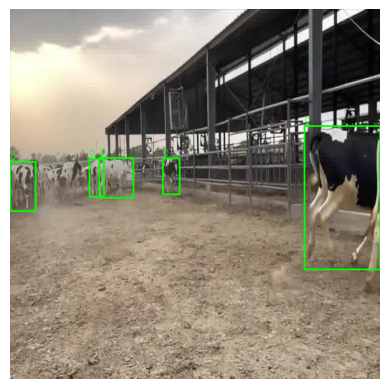

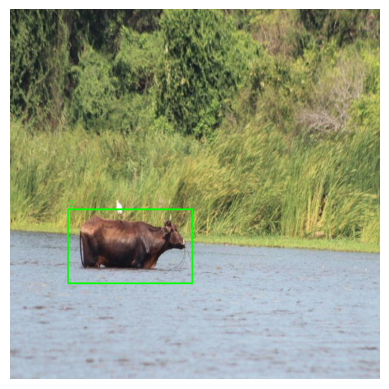

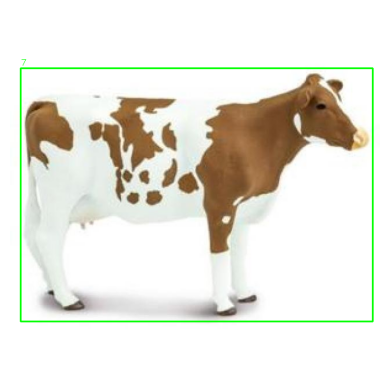

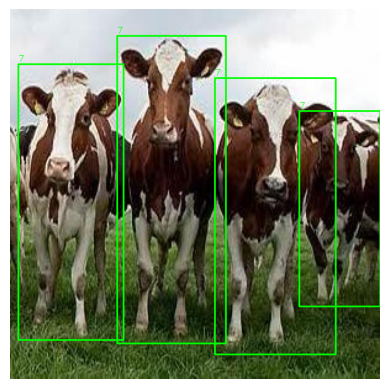

In [ ]:

images_dir = '/content/drive/MyDrive/archive (11)/train/images'
labels_dir = '/content/drive/MyDrive/archive (11)/train/labels'

def plot_image_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    with open(label_path) as f:
        for line in f:
            cls, x_center, y_center, bw, bh = map(float, line.strip().split())
            x1 = int((x_center - bw / 2) * w)
            y1 = int((y_center - bh / 2) * h)
            x2 = int((x_center + bw / 2) * w)
            y2 = int((y_center + bh / 2) * h)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(img, str(int(cls)), (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

random_samples = random.sample(os.listdir(images_dir), 5)
for img_file in random_samples:
    label_file = img_file.rsplit('.',1)[0] + '.txt'
    plot_image_with_boxes(os.path.join(images_dir,img_file), os.path.join(labels_dir,label_file))


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

# Initialize CNN model without top layer for feature extraction
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

images_dir = '/content/drive/MyDrive/archive (11)/train/images'
label_dir = '/content/drive/MyDrive/archive (11)/train/labels'

# Get list of images and their labels (assuming filenames map)
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])

all_features = []
all_labels = []

for img_file in image_files:
    # Load and preprocess image
    img_path = os.path.join(images_dir, img_file)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features
    features = model.predict(x)
    all_features.append(features.flatten())

    # Get label class IDs from label file (pick first class if multi-class present)
    label_file = img_file.replace('.jpg', '.txt')
    with open(os.path.join(label_dir, label_file)) as f:
        lines = f.readlines()
        class_id = int(lines[0].split()[0]) if lines else -1  # -1 for empty label files
    all_labels.append(class_id)

all_features = np.array(all_features)
all_labels = np.array(all_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


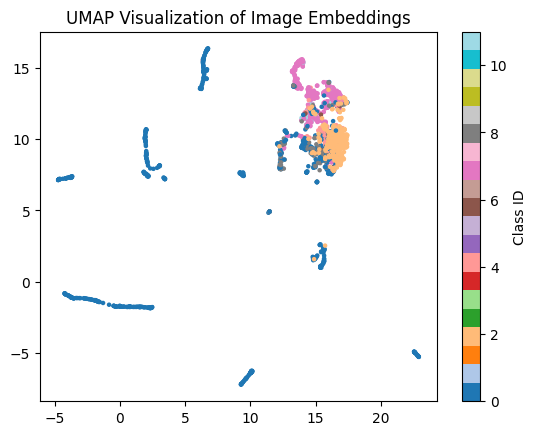

In [ ]:
import umap

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(all_features)

plt.scatter(embedding[:,0], embedding[:,1], c=all_labels, cmap='tab20', s=5)
plt.colorbar(label='Class ID')
plt.title('UMAP Visualization of Image Embeddings')
plt.show()


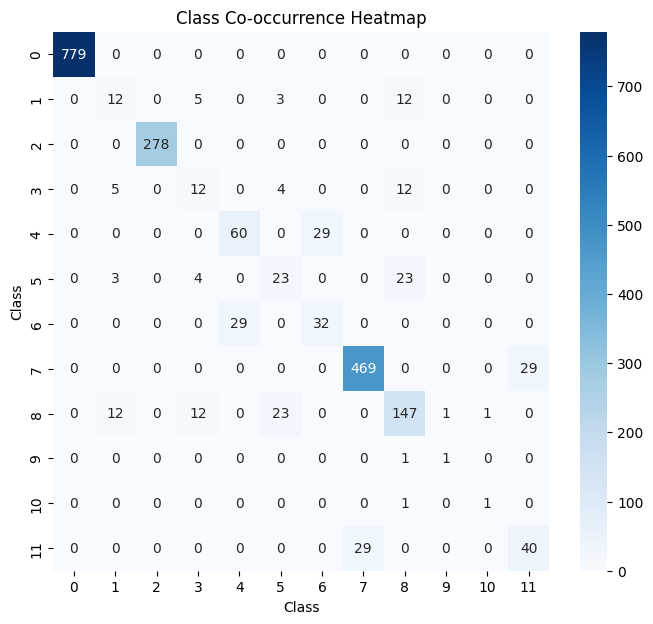

In [ ]:
import seaborn as sns
from collections import defaultdict


labels_dir = '/content/drive/MyDrive/archive (11)/train/labels'
num_classes = 12
cooc = np.zeros((num_classes, num_classes), dtype=int)

for label_file in os.listdir(labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(labels_dir, label_file)) as f:
            classes = set(int(line.split()[0]) for line in f)
            for c1 in classes:
                for c2 in classes:
                    cooc[c1, c2] += 1

plt.figure(figsize=(8,7))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Class')
plt.ylabel('Class')
plt.title('Class Co-occurrence Heatmap')
plt.show()

## 3. Data Preparation

This involved steps to prepare the data for model training:
- **Filtering Classes:** Removing classes with low occurrences.
- **Splitting Dataset:** Dividing the dataset into training, validation, and test sets.
- **Data Augmentation:** Applying transformations to the training data to increase its size and variability, particularly to address class imbalance.
- **Updating Data Configuration:** Modifying the `data.yaml` file to reflect the changes in the dataset (e.g., number of classes, updated paths).

In [7]:
import os
import shutil

dataset_path = '/content/drive/MyDrive/archive (11)'
labels_path = os.path.join(dataset_path, 'train', 'labels')
images_path = os.path.join(dataset_path, 'train', 'images') # Assuming images are in a 'images' subdirectory

output_base_path = '/content/filtered_dataset_revisited' # New output path for this filtering
output_labels_path = os.path.join(output_base_path, 'train', 'labels')
output_images_path = os.path.join(output_base_path, 'train', 'images')

# Create output directories if they don't exist
os.makedirs(output_labels_path, exist_ok=True)
os.makedirs(output_images_path, exist_ok=True)

# Classes to drop based on the new criteria (< 50 occurrences)
classes_to_drop = [1, 3, 5, 9, 10]

# Process each label file
for filename in os.listdir(labels_path):
    if filename.endswith('.txt'):
        filepath = os.path.join(labels_path, filename)
        output_filepath = os.path.join(output_labels_path, filename)

        # Read all lines first to decide if the file should be copied
        with open(filepath, 'r') as infile:
            lines = infile.readlines()

        # Check if any line contains a class ID that is NOT in the classes to drop
        # If a file only contains classes to be dropped, we might not want to keep it
        # However, for simplicity here, we'll just write lines that are not in dropped classes
        # and only create the file if there are lines to write.

        lines_to_write = [line for line in lines if int(line.split()[0]) not in classes_to_drop]

        if lines_to_write:
            with open(output_filepath, 'w') as outfile:
                outfile.writelines(lines_to_write)

            # Copy the corresponding image file only if the label file was created
            image_filename = filename.replace('.txt', '.jpg') # Assuming images are .jpg, adjust if needed
            image_filepath = os.path.join(images_path, image_filename)
            output_image_filepath = os.path.join(output_images_path, image_filename)

            if os.path.exists(image_filepath):
                shutil.copy(image_filepath, output_image_filepath)
            else:
                print(f"Warning: Image file not found for label {filename}")
        else:
             # If the label file is empty after removing classes, don't copy the image either
             print(f"Info: Label file {filename} contains only classes to be dropped. Not copying image.")


print(f"Processed labels and images. Filtered out classes: {classes_to_drop}")
print(f"Filtered dataset saved to: {output_base_path}")

Processed labels and images. Filtered out classes: [1, 3, 5, 9, 10]
Filtered dataset saved to: /content/filtered_dataset_revisited


In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to the filtered dataset (updated to the new filtering output)
filtered_dataset_path = '/content/filtered_dataset_revisited'
filtered_images_path = os.path.join(filtered_dataset_path, 'train', 'images') # The filtered images are in the 'train' subfolder of the filtered dataset
filtered_labels_path = os.path.join(filtered_dataset_path, 'train', 'labels') # The filtered labels are in the 'train' subfolder of the filtered dataset

# Define the output base path for the split dataset (can use the same path if we overwrite, or a new one)
output_base_path_split = '/content/split_dataset' # Keeping the same output path for split dataset

# Create output directories for train, val, and test splits
train_images_path = os.path.join(output_base_path_split, 'train', 'images')
train_labels_path = os.path.join(output_base_path_split, 'train', 'labels')
val_images_path = os.path.join(output_base_path_split, 'val', 'images')
val_labels_path = os.path.join(output_base_path_split, 'val', 'labels')
test_images_path = os.path.join(output_base_path_split, 'test', 'images')
test_labels_path = os.path.join(output_base_path_split, 'test', 'labels')

# Clean up previous split data before creating new ones
if os.path.exists(output_base_path_split):
    shutil.rmtree(output_base_path_split)

os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)


# Get list of image files (assuming image and label filenames match except for extension)
image_filenames = [f for f in os.listdir(filtered_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Split filenames into train, validation, and test sets
train_filenames, test_filenames = train_test_split(image_filenames, test_size=0.1, random_state=42) # 10% for test
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2/0.9, random_state=42) # Split remaining 90% into train (70%) and val (20%)

print(f"Total images: {len(image_filenames)}")
print(f"Train images: {len(train_filenames)}")
print(f"Validation images: {len(val_filenames)}")
print(f"Test images: {len(test_filenames)}")

# Function to copy image and label files
def copy_files(filenames, image_src_path, label_src_path, image_dest_path, label_dest_path):
    for filename in filenames:
        # Copy image
        src_image_path = os.path.join(image_src_path, filename)
        dest_image_path = os.path.join(image_dest_path, filename)
        shutil.copy(src_image_path, dest_image_path)

        # Copy label
        label_filename = filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt') # Adjust extension
        src_label_path = os.path.join(label_src_path, label_filename)
        dest_label_path = os.path.join(label_dest_path, label_filename)
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dest_label_path)
        else:
            print(f"Warning: Label file not found for image {filename}")

# Copy files to their respective split directories
copy_files(train_filenames, filtered_images_path, filtered_labels_path, train_images_path, train_labels_path)
copy_files(val_filenames, filtered_images_path, filtered_labels_path, val_images_path, val_labels_path)
copy_files(test_filenames, filtered_images_path, filtered_labels_path, test_images_path, test_labels_path)

print(f"Dataset split complete. Split dataset saved to: {output_base_path_split}")

Total images: 1747
Train images: 1222
Validation images: 350
Test images: 175
Dataset split complete. Split dataset saved to: /content/split_dataset


In [9]:
import albumentations as A
import cv2
import os
import shutil
import random
from collections import Counter
import math
import yaml
import numpy as np # Import numpy for bounding box validation

# Define the augmentation pipeline (refined and potentially more aggressive)
# Updated transforms based on common usage and addressing warnings
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(p=0.3),
    A.CLAHE(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.3),
    A.Affine(shear={"x": (-15, 15), "y": (-15, 15)}, p=0.3), # Corrected Affine transform
    A.GaussNoise(p=0.3),
    A.Perspective(p=0.3),
    # Updated RandomResizedCrop parameters - removed 'height' and 'width' from init if not supported
    A.RandomResizedCrop(size=(640, 640), scale=(0.5, 1.0), ratio=(0.75, 1.33), p=0.3),
    A.RGBShift(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.RandomFog(p=0.3),
    A.RandomRain(p=0.3),
    A.RandomShadow(p=0.3),
    A.RandomSnow(p=0.3),
    A.RandomSunFlare(p=0.3),
    A.ToGray(p=0.1),
    A.ChannelShuffle(p=0.1),
    # Updated CoarseDropout parameters - removed invalid arguments
    A.CoarseDropout(p=0.1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Define input and output directories for the training set
input_base_path_train = '/content/split_dataset/train'
input_images_path_train = os.path.join(input_base_path_train, 'images')
input_labels_path_train = os.path.join(input_base_path_train, 'labels')

output_base_path_train_augmented = '/content/split_dataset/train_augmented_balanced' # New directory for balanced augmented training data
output_images_path_train_augmented = os.path.join(output_base_path_train_augmented, 'images')
output_labels_path_train_augmented = os.path.join(output_base_path_train_augmented, 'labels')

# Create output directories, clearing previous augmented data
if os.path.exists(output_base_path_train_augmented):
    shutil.rmtree(output_base_path_train_augmented)
os.makedirs(output_images_path_train_augmented, exist_ok=True)
os.makedirs(output_labels_path_train_augmented, exist_ok=True)

# Define the classes that were NOT dropped (by their original class ID)
# Based on the latest filtering criteria (< 50 occurrences were dropped) - these are the classes we keep and augment
classes_to_keep_ids = [0, 2, 4, 6, 7, 8, 11]

# Create a mapping from original class ID to the new class ID
# The new class IDs will be 0 to len(classes_to_keep_ids) - 1
original_to_new_class_id = {original_id: new_id for new_id, original_id in enumerate(classes_to_keep_ids)}


# Function to load YOLO annotations and map class IDs
def load_yolo_annotations_mapped(label_filepath, original_to_new_map):
    bboxes = []
    class_labels = []
    if os.path.exists(label_filepath):
        with open(label_filepath, 'r') as f:
            for line in f:
                parts = line.split()
                if len(parts) >= 5: # Ensure the line has enough parts for a YOLO bbox
                    try:
                        original_class_id = int(parts[0])
                        if original_class_id in original_to_new_map:
                            new_class_id = original_to_new_map[original_class_id]
                            x_center, y_center, width, height = map(float, parts[1:])
                            bboxes.append([x_center, y_center, width, height])
                            class_labels.append(new_class_id)
                        # Else: ignore annotations for dropped classes
                    except ValueError:
                        print(f"Skipping invalid line in {label_filepath}: {line.strip()}")
    return bboxes, class_labels

# Function to save YOLO annotations (same as before, but uses mapped class IDs)
def save_yolo_annotations(label_filepath, bboxes, class_labels):
    with open(label_filepath, 'w') as f:
        for bbox, class_id in zip(bboxes, class_labels):
            # Ensure bounding box values are within [0, 1] after augmentation
            bbox = [max(0.0, min(1.0, val)) for val in bbox] # Ensure float values
            # Check for invalid bounding boxes (zero width or height)
            if bbox[2] > 0 and bbox[3] > 0:
                 # Explicitly format class_id as an integer
                f.write(f"{int(class_id)} {' '.join(map(str, bbox))}\n")
            else:
                # print(f"Warning: Skipping invalid bbox [w={bbox[2]}, h={bbox[3]}] for class {class_id} in {label_filepath}")
                pass # Silently skip invalid bounding boxes


# Target counts for all classes that were kept (aiming for a more balanced distribution, closer to Class 0's initial count)
# Let's set a more moderate target for underrepresented classes
initial_class_0_count = 2167 # From previous output
target_count_for_minority_classes = int(initial_class_0_count * 0.5) # Aim for 50% of Class 0 count as a target for minority classes

# Initialize target counts only for the classes we are keeping and want to augment
classes_to_augment_ids = [id for id in classes_to_keep_ids if id != 0] # Exclude class 0 from augmentation target
target_counts = {class_id: target_count_for_minority_classes for class_id in classes_to_augment_ids}
# Keep the target for class 0 as its original count (no augmentation)
target_counts[0] = initial_class_0_count


# Get current class counts in the training set (from split data) - using original class IDs for this count
current_class_counts_original_ids = Counter()
image_files_with_class_instances = {class_id: [] for class_id in classes_to_keep_ids} # To store (image_filename, original_bbox, original_class_id) for each instance

for filename in os.listdir(input_labels_path_train):
    if filename.endswith('.txt'):
        filepath = os.path.join(input_labels_path_train, filename)
        image_filename = filename.replace('.txt', '.jpg') # Assuming images are .jpg
        image_filepath = os.path.join(input_images_path_train, image_filename)

        if os.path.exists(image_filepath):
            with open(filepath, 'r') as f:
                for line in f:
                    parts = line.split()
                    if len(parts) >= 5:
                        try:
                            original_class_id = int(parts[0])
                            if original_class_id in classes_to_keep_ids:
                                current_class_counts_original_ids[original_class_id] += 1
                                bbox = list(map(float, parts[1:]))
                                image_files_with_class_instances[original_class_id].append((image_filename, bbox, original_class_id))
                        except ValueError:
                             print(f"Skipping invalid line in {filepath}: {line.strip()}")
        else:
            print(f"Warning: Image file not found for label {filename}")


print("Initial class counts in training set (original IDs):")
for class_id, count in sorted(current_class_counts_original_ids.items()):
    print(f"Class ID {class_id}: {count} occurrences")


# Copy original images and labels to the augmented directory (with class ID mapping)
for filename in os.listdir(input_images_path_train):
     if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_filename_only = filename
        image_filepath = os.path.join(input_images_path_train, image_filename_only)
        label_filename = filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_filepath = os.path.join(input_labels_path_train, label_filename)

        output_image_filename_orig = "original_" + image_filename_only
        output_label_filename_orig = "original_" + label_filename
        output_image_filepath_orig = os.path.join(output_images_path_train_augmented, output_image_filename_orig)
        output_label_filepath_orig = os.path.join(output_labels_path_train_augmented, output_label_filename_orig)


        if os.path.exists(image_filepath) and os.path.exists(label_filepath):
            # Load original annotations, map class IDs, and save to the new location
            bboxes, class_labels = load_yolo_annotations_mapped(label_filepath, original_to_new_class_id)
            if bboxes: # Only copy if there are labels for kept classes
                shutil.copy(image_filepath, output_image_filepath_orig)
                save_yolo_annotations(output_label_filepath_orig, bboxes, class_labels)
        # else:
            # print(f"Warning: Image or label file not found for original copy {image_filename_only}")


# Perform targeted augmentation for classes below the target count
augmented_class_counts = Counter() # Initialize augmented counts to be separate
# Copy initial counts for classes not being augmented
for original_class_id, count in current_class_counts_original_ids.items():
    if original_class_id not in classes_to_augment_ids:
         # Map original class ID to new class ID for initial count in augmented_class_counts
         if original_class_id in original_to_new_class_id:
            augmented_class_counts[original_to_new_class_id[original_class_id]] = count
         else:
             # This case should ideally not happen if classes_to_keep_ids is consistent
             print(f"Warning: Original class ID {original_class_id} not found in original_to_new_class_id mapping.")


max_augmentations_per_image = 15 # Cap the number of times a single image is augmented

for original_class_id in classes_to_augment_ids: # Iterate only through classes to augment
    # Use the mapped class ID for checking against augmented_class_counts
    new_class_id = original_to_new_class_id.get(original_class_id)
    if new_class_id is None:
        print(f"Error: Original class ID {original_class_id} not found in mapping. Skipping augmentation.")
        continue

    needed_augmentations = target_counts.get(original_class_id, 0) - augmented_class_counts.get(new_class_id, 0)
    instances_of_this_class = image_files_with_class_instances.get(original_class_id, [])

    if needed_augmentations > 0 and instances_of_this_class:
        print(f"Augmenting class (original ID) {original_class_id} (new ID {new_class_id}): Need {needed_augmentations} more occurrences.")

        # Create a pool of images to augment, weighted by the number of instances of this class they contain
        augmentation_pool = []
        for image_filename, bbox, cls_id in instances_of_this_class:
            # Add the image filename to the pool for each instance of this class it contains
            augmentation_pool.append(image_filename)

        # Augment images until the target count is reached for this class
        image_augmentation_counts = Counter() # Track how many times each image has been augmented for this class

        while augmented_class_counts.get(new_class_id, 0) < target_counts.get(original_class_id, 0) and augmentation_pool:
            # Select an image to augment from the pool
            selected_image_filename = random.choice(augmentation_pool)
            image_augmentation_counts[selected_image_filename] += 1

            # Avoid augmenting a single image excessively
            if image_augmentation_counts[selected_image_filename] > max_augmentations_per_image:
                 # Remove this image from the pool if it has been augmented too many times
                 augmentation_pool = [f for f in augmentation_pool if f != selected_image_filename]
                 # print(f"Info: Reached max augmentations ({max_augmentations_per_image}) for image {selected_image_filename} for class {original_class_id}. Removing from pool.")
                 continue # Move to the next iteration

            image_filepath = os.path.join(input_images_path_train, selected_image_filename)
            label_filename = selected_image_filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
            label_filepath = os.path.join(input_labels_path_train, label_filename)

            if os.path.exists(image_filepath) and os.path.exists(label_filepath):
                try:
                    image = cv2.imread(image_filepath)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Load annotations using the mapping function
                    bboxes, class_labels = load_yolo_annotations_mapped(label_filepath, original_to_new_class_id)

                    if not bboxes:
                         # print(f"Info: Skipping augmentation for {selected_image_filename} as it has no valid bboxes after mapping.")
                         # Remove this image from the pool if it has no valid bboxes after mapping
                         augmentation_pool = [f for f in augmentation_pool if f != selected_image_filename]
                         continue # Skip augmentation if no valid bboxes are found after mapping

                    try:
                        augmented = augmentations(image=image, bboxes=bboxes, class_labels=class_labels)
                        augmented_image = augmented['image']
                        augmented_bboxes = augmented['bboxes']
                        augmented_class_labels = augmented['class_labels']

                        # Save augmented image
                        aug_idx = image_augmentation_counts[selected_image_filename] - 1 # Get the current augmentation index for this image
                        output_image_filename_aug = f"aug_cls{original_class_id}_img_{os.path.splitext(selected_image_filename)[0]}_{aug_idx}.jpg" # Unique filename
                        output_image_filepath_aug = os.path.join(output_images_path_train_augmented, output_image_filename_aug)
                        cv2.imwrite(output_image_filepath_aug, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

                        # Save augmented annotations
                        output_label_filename_aug = f"aug_cls{original_class_id}_img_{os.path.splitext(selected_image_filename)[0]}_{aug_idx}.txt" # Unique filename
                        output_label_filepath_aug = os.path.join(output_labels_path_train_augmented, output_label_filename_aug)
                        save_yolo_annotations(output_label_filepath_aug, augmented_bboxes, augmented_class_labels)

                        # Count the number of instances of the current class in the augmented image
                        # Use original_to_new_class_id mapping to count instances based on the *new* class ID
                        current_class_instances_in_aug = sum(1 for cls in augmented_class_labels if new_class_id == cls)

                        # Update the augmented class count for the new class ID
                        augmented_class_counts[new_class_id] += current_class_instances_in_aug


                    except Exception as e:
                        print(f"Error applying augmentation to {selected_image_filename} for class {original_class_id}: {e}")
                        # If augmentation fails for this image, remove it from the pool to avoid infinite loops
                        augmentation_pool = [f for f in augmentation_pool if f != selected_image_filename]


                except Exception as e:
                     print(f"Error processing image {selected_image_filename} for augmentation: {e}")
                     # If processing fails, remove from pool
                     augmentation_pool = [f for f in augmentation_pool if f != selected_image_filename]


            else:
                print(f"Warning: Image or label file not found for {selected_image_filename} during augmentation of class {original_class_id}. Removing from pool.")
                augmentation_pool = [f for f in augmentation_pool if f != selected_image_filename] # Remove from pool if files not found

# Recalculate actual class counts in the augmented training set after saving
final_class_counts = Counter()
for filename in os.listdir(output_labels_path_train_augmented):
    if filename.endswith('.txt'):
        filepath = os.path.join(output_labels_path_train_augmented, filename)
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.split()
                if len(parts) >= 1:
                    try:
                        # Ensure the class_id is treated as an integer
                        class_id = int(float(parts[0]))
                        final_class_counts[class_id] += 1
                    except ValueError:
                        # print(f"Skipping invalid line in {filepath}: {line.strip()}")
                        pass # Silently skip invalid lines


print(f"Refined data augmentation complete for the training set. Augmented data saved to: {output_base_path_train_augmented}")
print("Actual final class counts in augmented training set:")
for class_id, count in sorted(final_class_counts.items()):
    print(f"Class ID {class_id}: {count} occurrences")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Initial class counts in training set (original IDs):
Class ID 0: 2167 occurrences
Class ID 2: 232 occurrences
Class ID 4: 45 occurrences
Class ID 6: 47 occurrences
Class ID 7: 564 occurrences
Class ID 8: 345 occurrences
Class ID 11: 64 occurrences
Augmenting class (original ID) 2 (new ID 1): Need 1083 more occurrences.
Augmenting class (original ID) 4 (new ID 2): Need 1083 more occurrences.
Augmenting class (original ID) 6 (new ID 3): Need 1083 more occurrences.
Augmenting class (original ID) 7 (new ID 4): Need 1083 more occurrences.
Augmenting class (original ID) 8 (new ID 5): Need 1083 more occurrences.
Augmenting class (original ID) 11 (new ID 6): Need 1083 more occurrences.
Refined data augmentation complete for the training set. Augmented data saved to: /content/split_dataset/train_augmented_balanced
Actual final class counts in augmented training set:
Class ID 0: 2167 occurrences
Class ID 1: 1315 occurrences
Class ID 2: 1065 occurrences
Class ID 3: 1329 occurrences
Class ID 4: 28

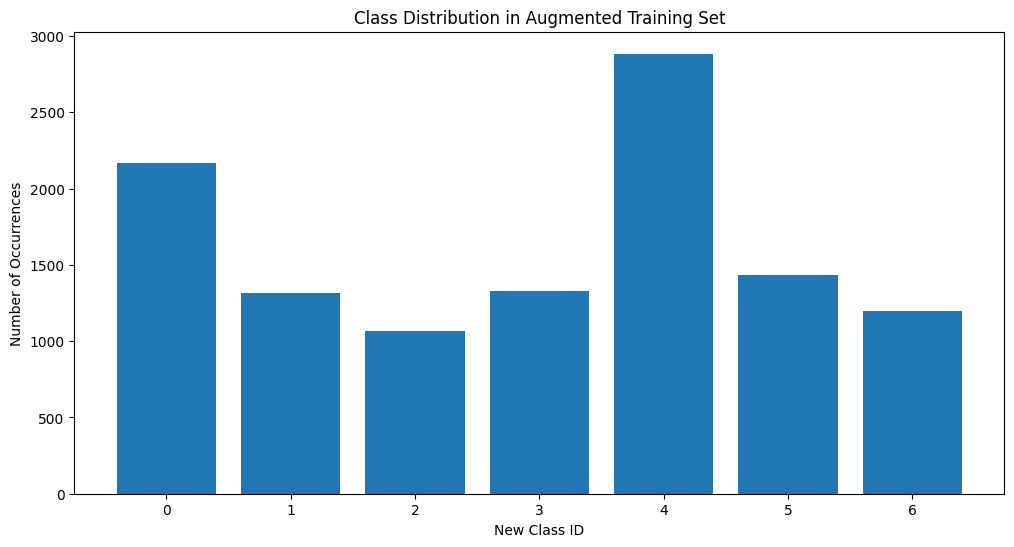

Actual final class counts in augmented training set (new IDs):
Class ID 0: 2167 occurrences
Class ID 1: 1315 occurrences
Class ID 2: 1065 occurrences
Class ID 3: 1329 occurrences
Class ID 4: 2884 occurrences
Class ID 5: 1433 occurrences
Class ID 6: 1199 occurrences


In [10]:
import matplotlib.pyplot as plt
from collections import Counter
import os

# Define the path to the augmented training labels directory
augmented_labels_path = '/content/split_dataset/train_augmented_balanced/labels' # Use the path to your augmented labels

# Check if the augmented labels directory exists
if not os.path.exists(augmented_labels_path):
    print(f"Error: Augmented labels directory not found at {augmented_labels_path}")
else:
    final_class_counts = Counter()

    # Iterate through each label file in the augmented directory
    for filename in os.listdir(augmented_labels_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(augmented_labels_path, filename)
            with open(filepath, 'r') as f:
                for line in f:
                    # YOLO format: class_id center_x center_y width height
                    parts = line.split()
                    if len(parts) > 0: # Ensure the line is not empty
                        try:
                            # Ensure the class_id is treated as an integer
                            class_id = int(float(parts[0]))
                            final_class_counts[class_id] += 1
                        except ValueError:
                            # print(f"Skipping invalid line in {filepath}: {line.strip()}")
                            pass # Silently skip invalid lines

    # Sort the class counts by class ID for consistent plotting
    sorted_final_class_counts = dict(sorted(final_class_counts.items()))

    # Prepare data for plotting
    class_ids = list(sorted_final_class_counts.keys())
    counts = list(sorted_final_class_counts.values())

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(class_ids, counts)
    plt.xlabel('New Class ID') # Label for the new mapped class IDs
    plt.ylabel('Number of Occurrences')
    plt.title('Class Distribution in Augmented Training Set')
    plt.xticks(class_ids) # Set x-axis ticks to be the class IDs
    plt.show()

    print("Actual final class counts in augmented training set (new IDs):")
    for class_id, count in sorted_final_class_counts.items():
        print(f"Class ID {class_id}: {count} occurrences")

In [ ]:
import yaml
import os

# Define the path to the original data.yaml file
dataset_path = '/content/drive/MyDrive/archive (11)'
data_yaml_path = os.path.join(dataset_path, 'data.yaml')

# Define the path where the updated data.yaml will be saved
output_data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Load the existing data.yaml file to get the original names (this is mainly for reference)
original_data = {}
if os.path.exists(data_yaml_path):
    with open(data_yaml_path, 'r') as f:
        original_data = yaml.safe_load(f)
    original_names = original_data.get('names', []) # Get original names, default to empty list if not found
else:
    print(f"Warning: Original data.yaml not found at {data_yaml_path}. Cannot retrieve original class names.")
    original_names = [] # Set original names to empty list if file not found

# Define the classes that were kept (by their original class ID)
# Based on the latest filtering criteria (< 50 occurrences were dropped)
classes_to_keep_ids = [0, 2, 4, 6, 7, 8, 11]

# Update nc (number of classes) to be the count of classes that were kept
data = {} # Initialize a new dictionary for the updated data
data['nc'] = len(classes_to_keep_ids)

# Remove the 'names' entry as requested by the user
# data['names'] = updated_names # Commenting out or removing this line

# Update paths to the split dataset
# Use absolute paths for the split dataset directories
data['train'] = '/content/split_dataset/train_augmented_balanced/images' # Point to the corrected augmented training images directory
data['val'] = '/content/split_dataset/val/images'         # Point to the validation images
data['test'] = '/content/split_dataset/test/images'       # Point to the test images


# Remove roboflow specific entries if you are not using roboflow for training
if 'roboflow' in original_data: # Check in original data to avoid errors if 'roboflow' key is missing
    del original_data['roboflow'] # Removing from original_data might be safer or just skip this part if not needed


# Save the updated data.yaml file
with open(output_data_yaml_path, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

print(f"Updated data.yaml saved to: {output_data_yaml_path}")
print("Updated data.yaml content:")
with open(output_data_yaml_path, 'r') as f:
    print(f.read())

Updated data.yaml saved to: /content/drive/MyDrive/archive (11)/data.yaml
Updated data.yaml content:
nc: 7
test: /content/split_dataset/test/images
train: /content/split_dataset/train_augmented_balanced/images
val: /content/split_dataset/val/images



## 4. Model Training and Evaluation (YOLOv8 Variants)

Here, we trained and evaluated different variants of the YOLOv8 object detection model on the prepared dataset:
- **Training:** Training YOLOv8n, YOLOv8s, YOLOv8m, and YOLOv8l models.
- **Evaluation:** Evaluating each trained model on the test set to obtain performance metrics (mAP).
- **Comparison:** Comparing the performance metrics of the different YOLOv8 variants.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s eta 0:00:00


# Yolov8n

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8s model
model = YOLO('yolov8n.pt')

# Define the path to your updated data.yaml file
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Train the model with adjusted hyperparameters and refined augmented data
# Adjusting 'cls' (classification loss gain) and 'lrf' (learning rate factor)
# Note: This is an indirect way to address class imbalance compared to explicit class weights.
# Increasing 'cls' gives more importance to classification loss.
# Adjusting 'lrf' can help stabilize training with potentially increased classification sensitivity.
results = model.train(
    data=data_yaml_path,
    epochs=15, # Increased epochs
    imgsz=640,
    batch=16,
    cls=1.0,  # Increase classification loss gain (default is 0.5)
    lrf=0.005 # Decrease learning rate factor slightly (default is 0.01)
)

print("Model training complete with adjusted hyperparameters and refined data augmentation.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/archive (11)/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False,

In [ ]:
# Define the path to your updated data.yaml file (should be the same as used for training)
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'


# Evaluate the loaded model on the test set
metrics_test = model.val(data=data_yaml_path, split='test')
print(metrics_test)

print("Model evaluation on the test set complete.")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1511.9±128.9 MB/s, size: 61.8 KB)
val: Scanning /content/split_dataset/test/labels... 175 images, 0 backgrounds, 59 corrupt: 100% ━━━━━━━━━━━━ 175/175 2.8Kit/s 0.1s
val: /content/split_dataset/test/images/-OWS_mp4-203_jpg.rf.237d66202ebd25127286a2bb941c4d7f.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/-OWS_mp4-423_jpg.rf.5c549f7b840391ab26b6d03a29eee193.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/Ayrshirecattle0_jpg.rf.109b38b256521bd26ac1135b282bc99e.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/Ayrshirecattle117_c_jpg.rf.84834c8789815291662f451

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os

# Define the path to your trained model weights
# Assuming the model was trained in a run directory like '/content/runs/detect/train8'
# You might need to adjust this path based on your actual training output
train_results_dir = '/content/runs/detect/train8' # <<<< Adjust this path if needed
best_model_path = os.path.join(train_results_dir, 'weights', 'best.pt')

# Load the trained model
try:
    model = YOLO(best_model_path)
except FileNotFoundError:
    print(f"Error: Trained model weights not found at {best_model_path}")
    print("Please ensure the path is correct and the training was successful.")
    model = None

if model:
    # Define the path to the image you want to predict on
    # Replace 'path/to/your/image.jpg' with the actual path
    image_to_predict_path = '/content/split_dataset/test/images/Ayrshirecattle134_jpg.rf.69e0b03c429b8165d89b2dacb78bcd89.jpg' # <<<< Change this to your image path

    if os.path.exists(image_to_predict_path):
        print(f"Making prediction on: {image_to_predict_path}")

        # Run inference on the image and save the results
        results = model.predict(
            source=image_to_predict_path,
            save=True,  # Save predicted image with bounding boxes
            save_conf=True, # Save confidence scores
            save_txt=False, # Don't save prediction in txt format
            classes=None, # Predict all classes in the model
            conf=0.25, # Confidence threshold
            iou=0.45, # IoU threshold for NMS
            project='runs/predict', # Directory to save results
            name='single_image_prediction' # Subdirectory within project
        )

        # Display the predicted image
        predicted_image_dir = os.path.join('runs/predict/single_image_prediction')
        # The saved image filename will be the same as the input image filename
        predicted_image_filename = os.path.basename(image_to_predict_path)
        predicted_image_path_display = os.path.join(predicted_image_dir, predicted_image_filename)

        if os.path.exists(predicted_image_path_display):
            print("\nDisplaying predicted image:")
            display(Image(filename=predicted_image_path_display))
        else:
            print(f"Predicted image not found at {predicted_image_path_display}")

    else:
        print(f"Error: Image not found at {image_to_predict_path}")
else:
    print("Model not loaded. Cannot make predictions.")

Error: Trained model weights not found at /content/runs/detect/train8/weights/best.pt
Please ensure the path is correct and the training was successful.
Model not loaded. Cannot make predictions.


## Model Prediction

Using the trained YOLOv8n models to make predictions on new, unseen images from the test set and visualizing the results.


Making prediction on: /content/split_dataset/test/images/hf02-224_jpeg_jpg.rf.50c274a2aeaa1dd729c8a9050999d46f.jpg

image 1/1 /content/split_dataset/test/images/hf02-224_jpeg_jpg.rf.50c274a2aeaa1dd729c8a9050999d46f.jpg: 640x640 4 0s, 9.4ms
Speed: 56.2ms preprocess, 9.4ms inference, 108.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction51

Displaying predicted image:


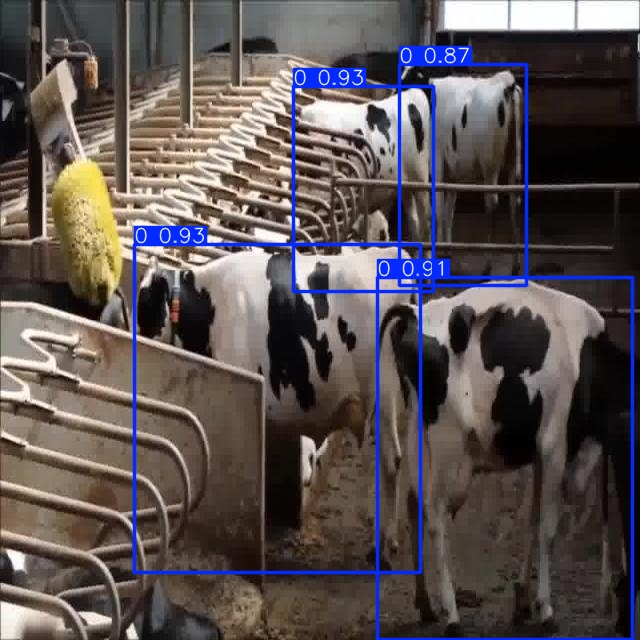


Making prediction on: /content/split_dataset/test/images/hf02-111_jpeg_jpg.rf.2ff3a70e22d56646f30ce00329b22e85.jpg

image 1/1 /content/split_dataset/test/images/hf02-111_jpeg_jpg.rf.2ff3a70e22d56646f30ce00329b22e85.jpg: 640x640 4 0s, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction52

Displaying predicted image:


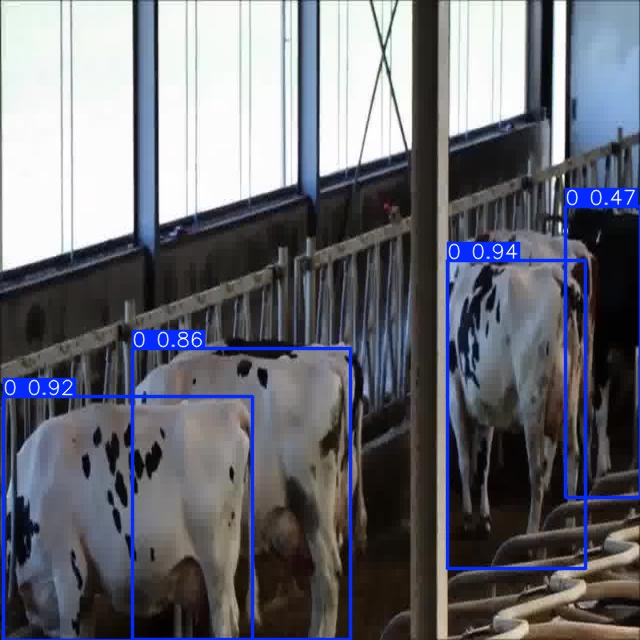


Making prediction on: /content/split_dataset/test/images/images_jpeg_jpg.rf.027b76d9573ed1e2e53ebdcc8d80abc5.jpg

image 1/1 /content/split_dataset/test/images/images_jpeg_jpg.rf.027b76d9573ed1e2e53ebdcc8d80abc5.jpg: 640x640 1 2, 2 4s, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction53

Displaying predicted image:


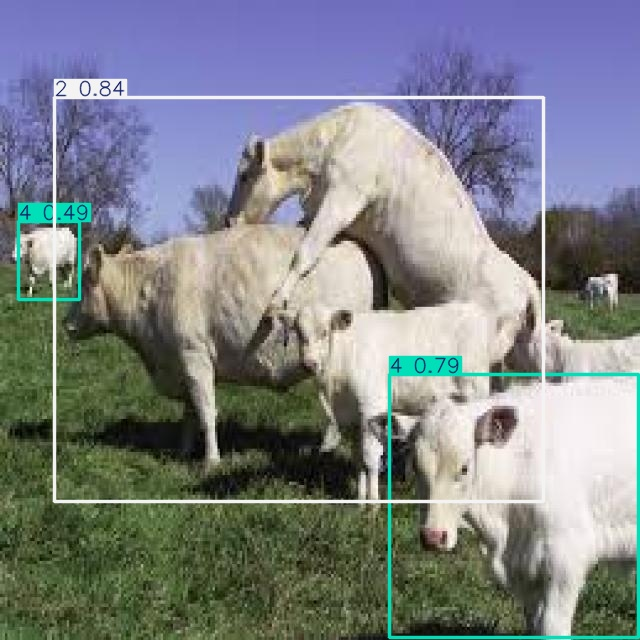


Making prediction on: /content/split_dataset/test/images/bedt8_jpeg_jpg.rf.11c596f26d3e9c67fd9b97b7f0051443.jpg

image 1/1 /content/split_dataset/test/images/bedt8_jpeg_jpg.rf.11c596f26d3e9c67fd9b97b7f0051443.jpg: 640x640 1 2, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction54

Displaying predicted image:


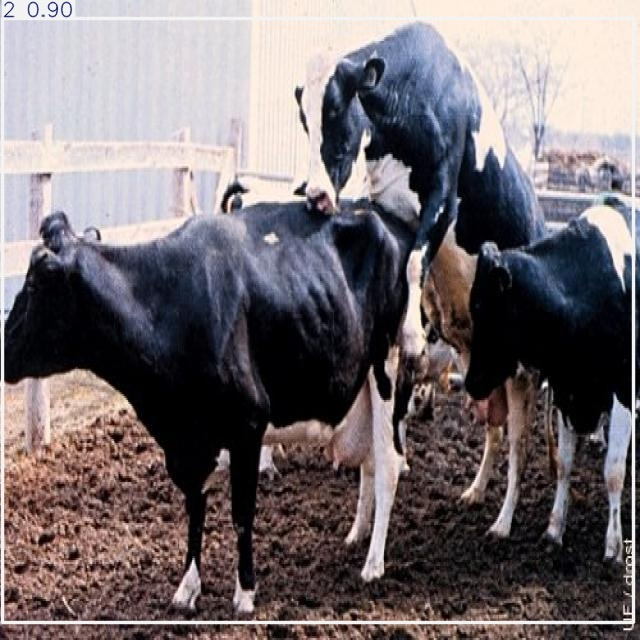


Making prediction on: /content/split_dataset/test/images/Ayrshirecattle31_c_jpg.rf.c20f12d0510c6dd0820ba9320accb9f3.jpg

image 1/1 /content/split_dataset/test/images/Ayrshirecattle31_c_jpg.rf.c20f12d0510c6dd0820ba9320accb9f3.jpg: 640x640 1 0, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction55

Displaying predicted image:


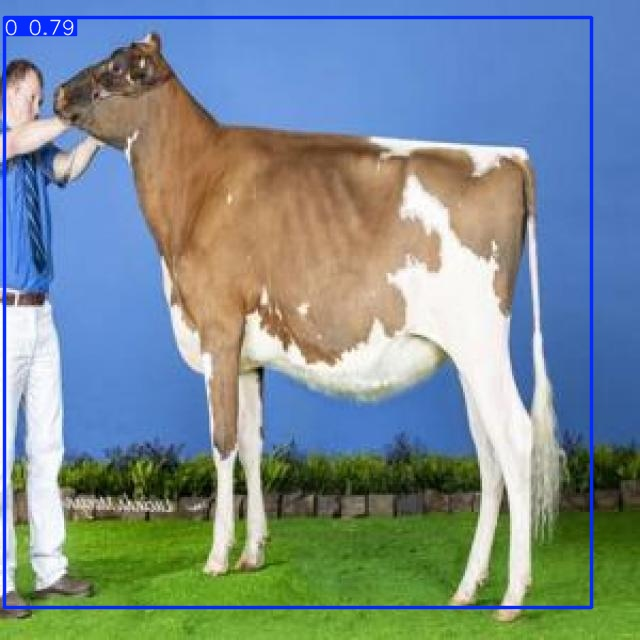


Making prediction on: /content/split_dataset/test/images/cow-trying-to-mount-photo_jpeg_jpg.rf.5a205172f605c255f693b56b28b23efc.jpg

image 1/1 /content/split_dataset/test/images/cow-trying-to-mount-photo_jpeg_jpg.rf.5a205172f605c255f693b56b28b23efc.jpg: 640x640 1 2, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction56

Displaying predicted image:


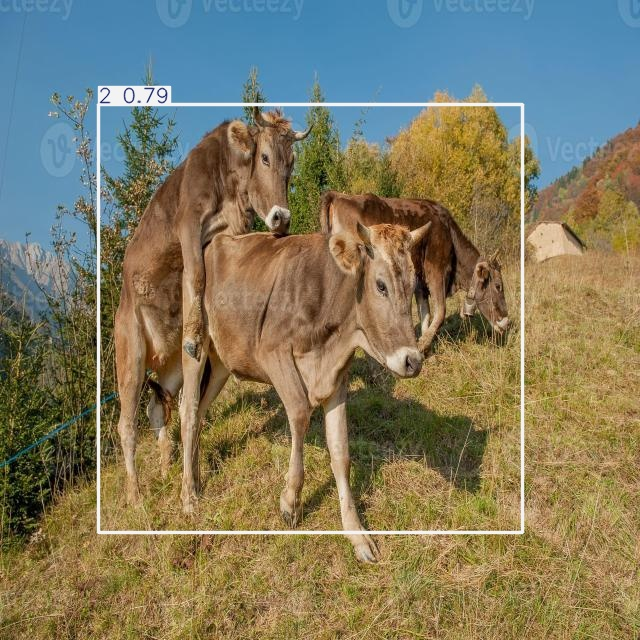


Making prediction on: /content/split_dataset/test/images/img00345_jpg.rf.a3567b24299f6b68d2a3a1d41878ff2c.jpg

image 1/1 /content/split_dataset/test/images/img00345_jpg.rf.a3567b24299f6b68d2a3a1d41878ff2c.jpg: 640x640 1 10, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction57

Displaying predicted image:


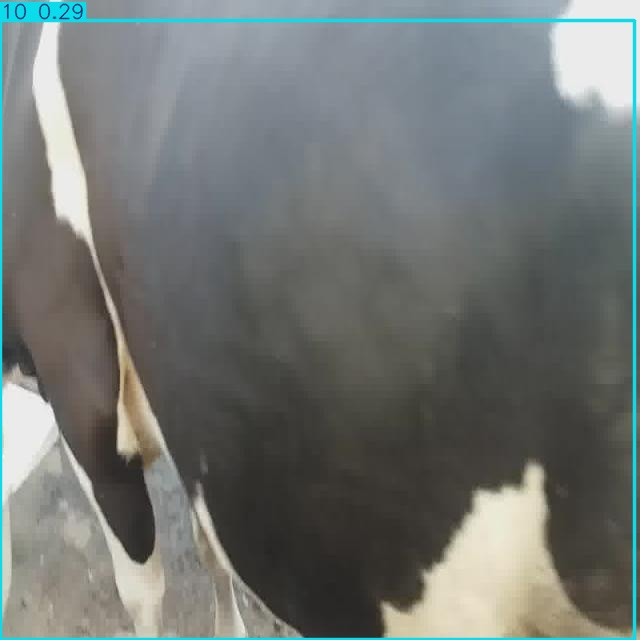


Making prediction on: /content/split_dataset/test/images/hf03-18_jpeg_jpg.rf.2c71e884d6ea65dbfc6c7727861932f6.jpg

image 1/1 /content/split_dataset/test/images/hf03-18_jpeg_jpg.rf.2c71e884d6ea65dbfc6c7727861932f6.jpg: 640x640 7 0s, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction58

Displaying predicted image:


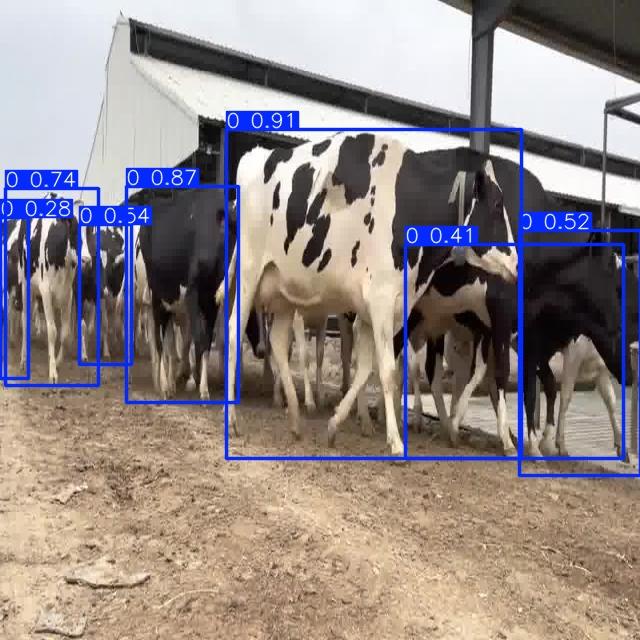


Making prediction on: /content/split_dataset/test/images/Ayrshirecattle28_c_jpg.rf.880f923347d80fb27780eba0f10b5adb.jpg

image 1/1 /content/split_dataset/test/images/Ayrshirecattle28_c_jpg.rf.880f923347d80fb27780eba0f10b5adb.jpg: 640x640 1 0, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction59

Displaying predicted image:


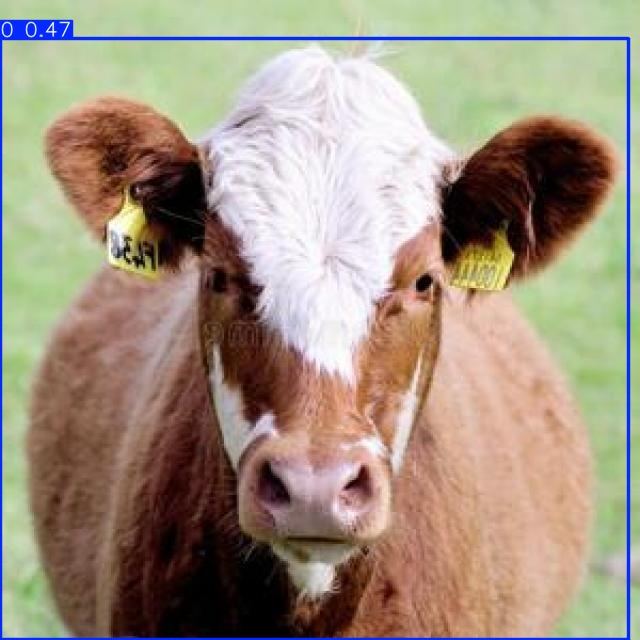


Making prediction on: /content/split_dataset/test/images/vaca37_jpg.rf.7c75be7e8e0d3a87aa062690f729d4bd.jpg

image 1/1 /content/split_dataset/test/images/vaca37_jpg.rf.7c75be7e8e0d3a87aa062690f729d4bd.jpg: 640x640 1 4, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/multiple_images_prediction60

Displaying predicted image:


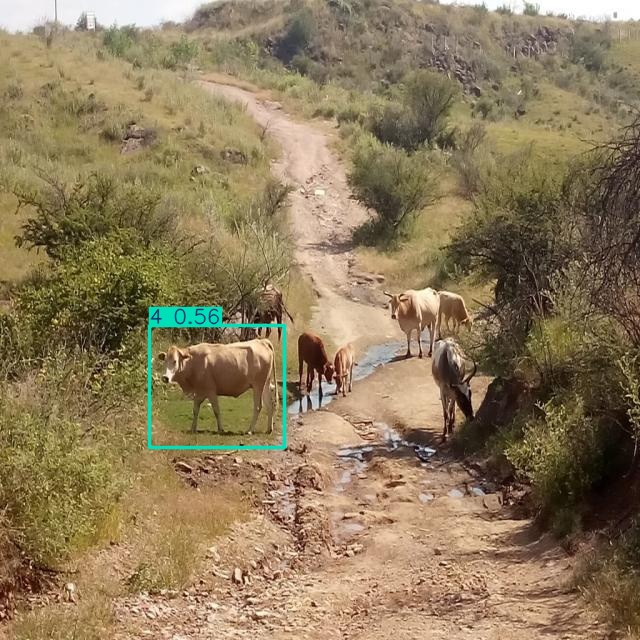

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os
import random

# Define the path to your trained model weights

train_results_dir = '/content/runs/detect/train' # <<<< Adjust this path if needed
best_model_path = os.path.join(train_results_dir, 'weights', 'best.pt')

# Load the trained model
try:
    model = YOLO(best_model_path)
except FileNotFoundError:
    print(f"Error: Trained model weights not found at {best_model_path}")
    print("Please ensure the path is correct and the training was successful.")
    model = None

if model:
    # Define the path to the test images directory
    test_images_dir = '/content/split_dataset/test/images'

    # Get a list of all image files in the test directory
    test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if test_image_files:
        # Select 10 random images from the test set
        num_images_to_predict = 10
        images_to_predict_filenames = random.sample(test_image_files, min(num_images_to_predict, len(test_image_files)))

        for image_to_predict_filename in images_to_predict_filenames:
            image_to_predict_path = os.path.join(test_images_dir, image_to_predict_filename)

            print(f"\nMaking prediction on: {image_to_predict_path}")

            # Run inference on the image and save the results
            
                source=image_to_predict_path,
                save=True,  # Save predicted image with bounding boxes
                save_conf=True, # Save confidence scores
                save_txt=False, # Don't save prediction in txt format
                classes=None, # Predict all classes in the model
                conf=0.25, # Confidence threshold
                iou=0.45, # IoU threshold for NMS
                project='runs/predict', # Directory to save results
                name='multiple_images_prediction' # Subdirectory within project
            )

            
            actual_save_dir = results[0].save_dir # results is a list of Results objects, take the first one

            # Construct the path to the saved image using the actual save directory
            predicted_image_path_display = os.path.join(actual_save_dir, image_to_predict_filename)


            if os.path.exists(predicted_image_path_display):
                print("\nDisplaying predicted image:")
                display(Image(filename=predicted_image_path_display))
            else:
                print(f"Predicted image not found at {predicted_image_path_display}")

    else:
        print(f"No images found in the test directory: {test_images_dir}")
else:
    print("Model not loaded. Cannot make predictions.")

# Yolov8s

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8s model
model = YOLO('yolov8s.pt')

# Define the path to your updated data.yaml file
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Train the model with adjusted hyperparameters and refined augmented data
# Adjusting 'cls' (classification loss gain) and 'lrf' (learning rate factor)
# Note: This is an indirect way to address class imbalance compared to explicit class weights.
# Increasing 'cls' gives more importance to classification loss.
# Adjusting 'lrf' can help stabilize training with potentially increased classification sensitivity.
results = model.train(
    data=data_yaml_path,
    epochs=15, # Increased epochs
    imgsz=640,
    batch=16,
    cls=1.0,  # Increase classification loss gain (default is 0.5)
    lrf=0.005 # Decrease learning rate factor slightly (default is 0.01)
)

print("Model training complete with adjusted hyperparameters and refined data augmentation.")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/archive (11)/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

In [ ]:
from ultralytics import YOLO
import os

# Define the path to your updated data.yaml file (should be the same as used for training)
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'


train_results_dir = '/content/runs/detect/train4' # <<<< Adjust this path if needed based on your training output
best_model_path = os.path.join(train_results_dir, 'weights', 'best.pt')

# Load the trained model
try:
    model = YOLO(best_model_path)
except FileNotFoundError:
    print(f"Error: Trained model weights not found at {best_model_path}")
    print("Please ensure the path is correct and the training was successful.")
    model = None

if model:
    # Evaluate the loaded model on the test set
    metrics_test = model.val(data=data_yaml_path, split='test')
    print(metrics_test)

    print("Model evaluation on the test set complete.")
else:
    print("Model not loaded. Cannot perform evaluation.")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 809.6±486.6 MB/s, size: 64.8 KB)
val: Scanning /content/split_dataset/test/labels.cache... 175 images, 0 backgrounds, 59 corrupt: 100% ━━━━━━━━━━━━ 175/175 265.0Kit/s 0.0s
val: /content/split_dataset/test/images/-OWS_mp4-203_jpg.rf.237d66202ebd25127286a2bb941c4d7f.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/-OWS_mp4-423_jpg.rf.5c549f7b840391ab26b6d03a29eee193.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/Ayrshirecattle0_jpg.rf.109b38b256521bd26ac1135b282bc99e.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
v

## Model Prediction

Using the trained YOLOv8s models to make predictions on new, unseen images from the test set and visualizing the results.


Making prediction on: /content/split_dataset/test/images/bedt8_jpeg_jpg.rf.11c596f26d3e9c67fd9b97b7f0051443.jpg

image 1/1 /content/split_dataset/test/images/bedt8_jpeg_jpg.rf.11c596f26d3e9c67fd9b97b7f0051443.jpg: 640x640 1 2, 1 4, 16.2ms
Speed: 1.6ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions47

Displaying predicted image:


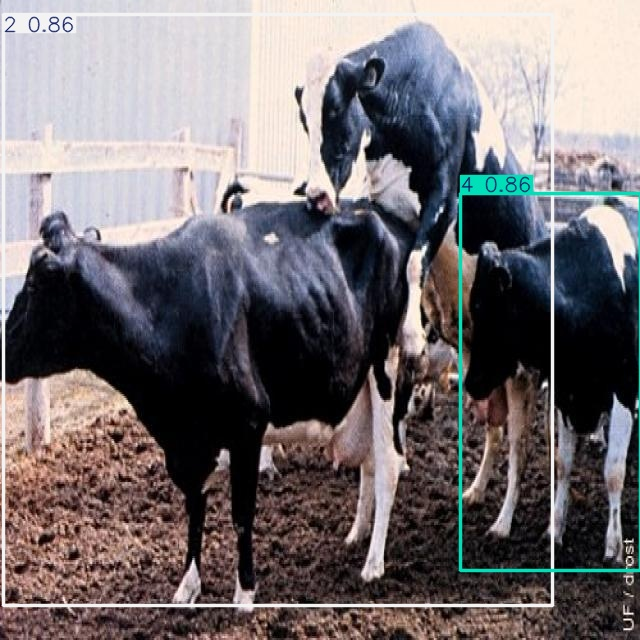


Making prediction on: /content/split_dataset/test/images/HolsteinFriesiancattle29_jpg.rf.25c39499a33951048168eb03b4542dac.jpg

image 1/1 /content/split_dataset/test/images/HolsteinFriesiancattle29_jpg.rf.25c39499a33951048168eb03b4542dac.jpg: 640x640 1 0, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions48

Displaying predicted image:


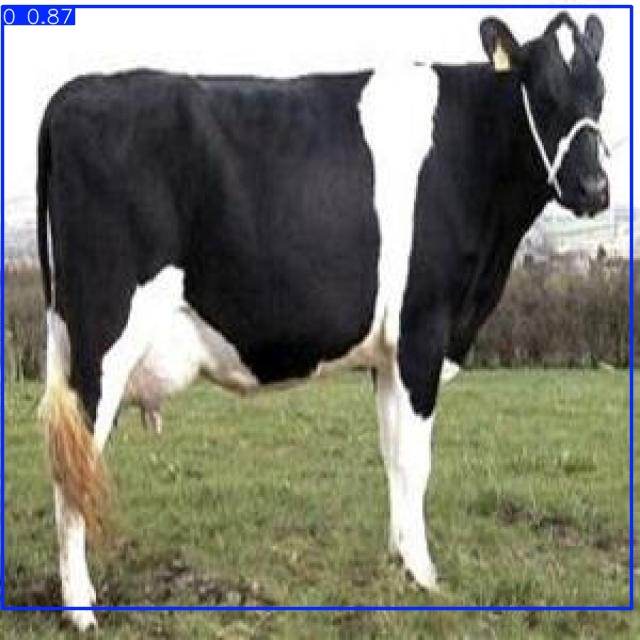


Making prediction on: /content/split_dataset/test/images/-OWS_mp4-203_jpg.rf.237d66202ebd25127286a2bb941c4d7f.jpg

image 1/1 /content/split_dataset/test/images/-OWS_mp4-203_jpg.rf.237d66202ebd25127286a2bb941c4d7f.jpg: 640x640 6 0s, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions49

Displaying predicted image:


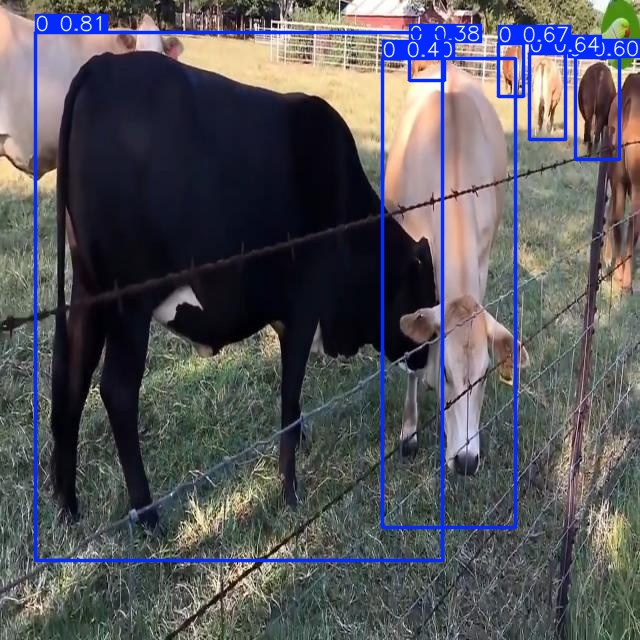


Making prediction on: /content/split_dataset/test/images/HolsteinFriesiancattle127_c_jpg.rf.5cf3f1b3c69c07f7cea72cea2e1f1941.jpg

image 1/1 /content/split_dataset/test/images/HolsteinFriesiancattle127_c_jpg.rf.5cf3f1b3c69c07f7cea72cea2e1f1941.jpg: 640x640 1 0, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions50

Displaying predicted image:


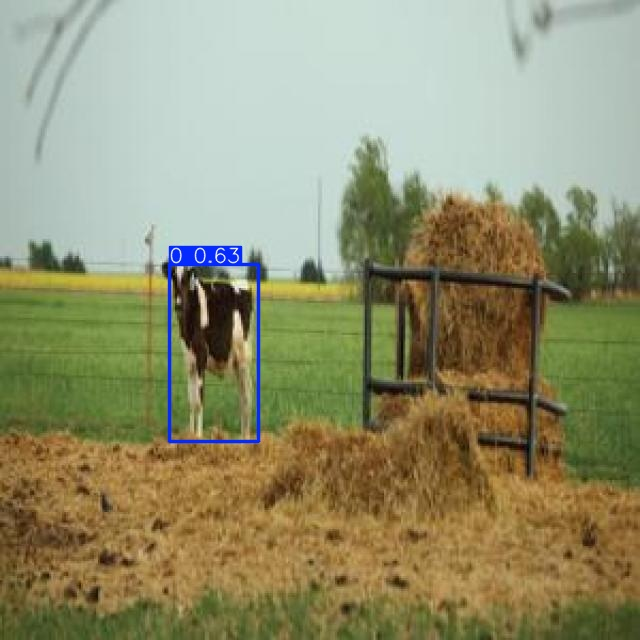


Making prediction on: /content/split_dataset/test/images/-OWS_mp4-628_jpg.rf.0bd28f4bc3b9924d2861ea8be721b97f.jpg

image 1/1 /content/split_dataset/test/images/-OWS_mp4-628_jpg.rf.0bd28f4bc3b9924d2861ea8be721b97f.jpg: 640x640 5 0s, 2 10s, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions51

Displaying predicted image:


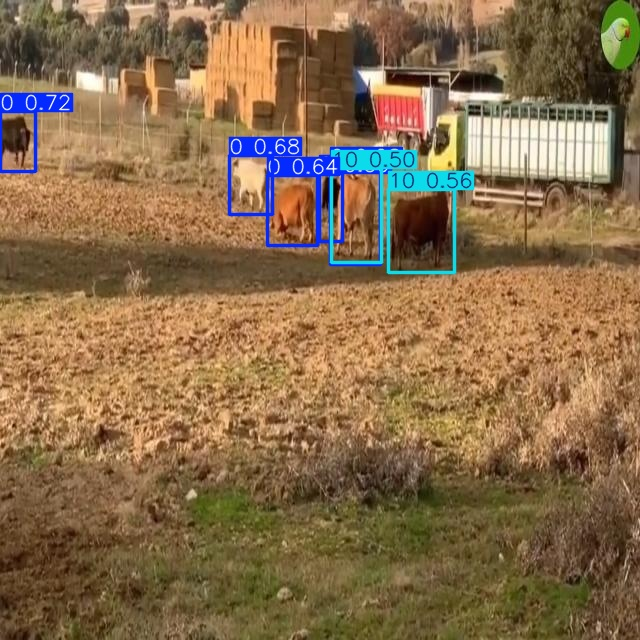

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os
import random

# Define the path to your trained YOLOv8s model weights
train_results_dir = '/content/runs/detect/train4' # <<<< Adjust this path if needed based on your YOLOv8s training output
best_model_path = os.path.join(train_results_dir, 'weights', 'best.pt')

# Load the trained YOLOv8s model
try:
    model_yolov8s = YOLO(best_model_path)
except FileNotFoundError:
    print(f"Error: Trained YOLOv8s model weights not found at {best_model_path}")
    print("Please ensure the path is correct and the YOLOv8s training was successful.")
    model_yolov8s = None

if model_yolov8s:
    # Define the path to the test images directory
    test_images_dir = '/content/split_dataset/test/images'

    # Get a list of all image files in the test directory
    test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if test_image_files:
        # Select 5 random images from the test set
        num_images_to_predict = 5
        images_to_predict_filenames = random.sample(test_image_files, min(num_images_to_predict, len(test_image_files)))

        # Define prediction output directory
        predict_output_dir = os.path.join('runs/predict', 'yolov8s_predictions')
        os.makedirs(predict_output_dir, exist_ok=True) # Ensure output directory exists

        for image_to_predict_filename in images_to_predict_filenames:
            image_to_predict_path = os.path.join(test_images_dir, image_to_predict_filename)

            print(f"\nMaking prediction on: {image_to_predict_path}")

            # Run inference on the image and save the results using the YOLOv8s model
            results = model_yolov8s.predict(
                source=image_to_predict_path,
                save=True,  # Save predicted image with bounding boxes
                save_conf=True, # Save confidence scores
                save_txt=False, # Don't save prediction in txt format
                classes=None, # Predict all classes in the model
                conf=0.25, # Confidence threshold
                iou=0.45, # IoU threshold for NMS
                project='runs/predict', # Directory to save results
                name='yolov8s_predictions' # Subdirectory within project
            )

            # Get the actual directory where the results were saved from the results object
            # The predicted image will be saved directly in this directory
            actual_save_dir = results[0].save_dir # results is a list of Results objects, take the first one

            # Construct the path to the saved image using the actual save directory
            predicted_image_path_display = os.path.join(actual_save_dir, image_to_predict_filename)


            if os.path.exists(predicted_image_path_display):
                print("\nDisplaying predicted image:")
                display(Image(filename=predicted_image_path_display))
            else:
                print(f"Predicted image not found at {predicted_image_path_display}")

    else:
        print(f"No images found in the test directory: {test_images_dir}")
else:
    print("YOLOv8s model not loaded. Cannot make predictions.")

# Yolov8m

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8s model
model = YOLO('yolov8m.pt')

# Define the path to your updated data.yaml file
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Train the model with adjusted hyperparameters and refined augmented data
# Adjusting 'cls' (classification loss gain) and 'lrf' (learning rate factor)
# Note: This is an indirect way to address class imbalance compared to explicit class weights.
# Increasing 'cls' gives more importance to classification loss.
# Adjusting 'lrf' can help stabilize training with potentially increased classification sensitivity.
results = model.train(
    data=data_yaml_path,
    epochs=15, # Increased epochs
    imgsz=640,
    batch=16,
    cls=1.0,  # Increase classification loss gain (default is 0.5)
    lrf=0.005 # Decrease learning rate factor slightly (default is 0.01)
)

print("Model training complete with adjusted hyperparameters and refined data augmentation.")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/archive (11)/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

In [ ]:
from ultralytics import YOLO
import os

# Define the path to your updated data.yaml file (should be the same as used for training)
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Define the path to the trained model weights
# Assuming the latest training run directory is 'train4' based on the previous output
train_results_dir = '/content/runs/detect/train5' # <<<< Adjust this path if needed based on your training output
best_model_path = os.path.join(train_results_dir, 'weights', 'best.pt')

# Load the trained model
try:
    model = YOLO(best_model_path)
except FileNotFoundError:
    print(f"Error: Trained model weights not found at {best_model_path}")
    print("Please ensure the path is correct and the training was successful.")
    model = None

if model:
    # Evaluate the loaded model on the test set
    metrics_test = model.val(data=data_yaml_path, split='test')
    print(metrics_test)

    print("Model evaluation on the test set complete.")
else:
    print("Model not loaded. Cannot perform evaluation.")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.3±8.8 MB/s, size: 64.8 KB)
val: Scanning /content/split_dataset/test/labels.cache... 175 images, 0 backgrounds, 59 corrupt: 100% ━━━━━━━━━━━━ 175/175 218.8Kit/s 0.0s
val: /content/split_dataset/test/images/-OWS_mp4-203_jpg.rf.237d66202ebd25127286a2bb941c4d7f.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/-OWS_mp4-423_jpg.rf.5c549f7b840391ab26b6d03a29eee193.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/Ayrshirecattle0_jpg.rf.109b38b256521bd26ac1135b282bc99e.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
val:

## Model Prediction

Using the trained YOLOv8m models to make predictions on new, unseen images from the test set and visualizing the results.


Making prediction on: /content/split_dataset/test/images/hf03-114_jpeg_jpg.rf.9d24915264f89764afa8ccf70518df6a.jpg

image 1/1 /content/split_dataset/test/images/hf03-114_jpeg_jpg.rf.9d24915264f89764afa8ccf70518df6a.jpg: 640x640 6 0s, 37.0ms
Speed: 10.1ms preprocess, 37.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions12

Displaying predicted image:


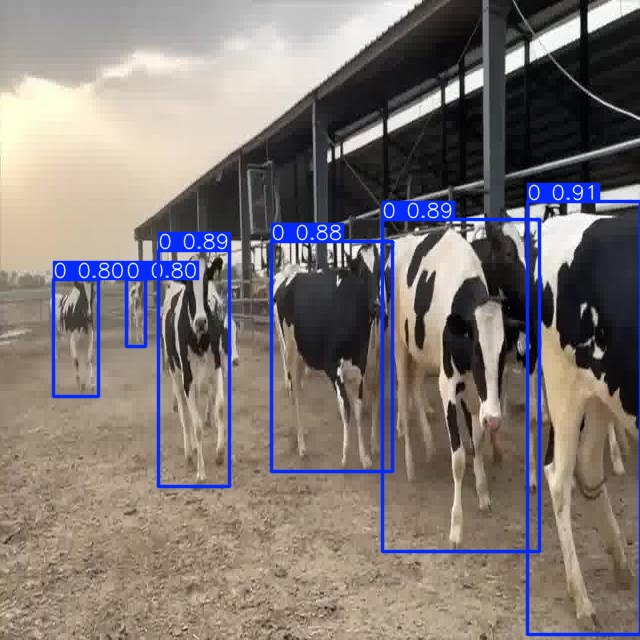


Making prediction on: /content/split_dataset/test/images/HolsteinFriesiancattle127_c_jpg.rf.5cf3f1b3c69c07f7cea72cea2e1f1941.jpg

image 1/1 /content/split_dataset/test/images/HolsteinFriesiancattle127_c_jpg.rf.5cf3f1b3c69c07f7cea72cea2e1f1941.jpg: 640x640 1 0, 37.0ms
Speed: 2.1ms preprocess, 37.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions13

Displaying predicted image:


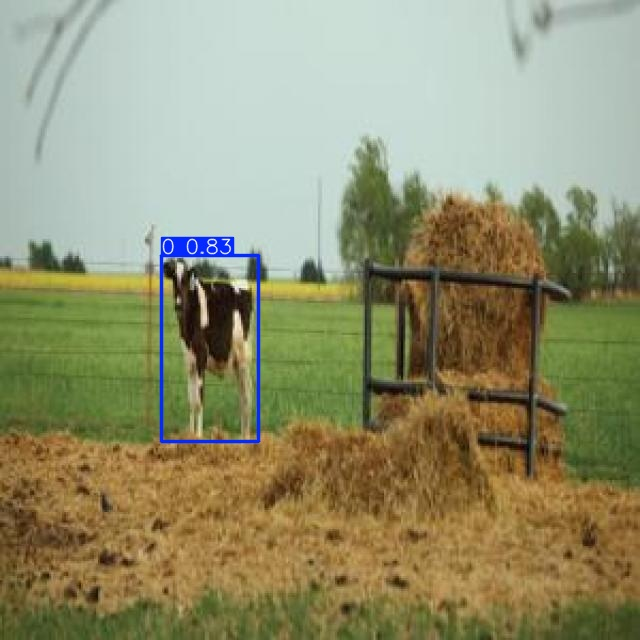


Making prediction on: /content/split_dataset/test/images/hf03-48_jpeg_jpg.rf.07d57256914ad679dab9598a86bbef4a.jpg

image 1/1 /content/split_dataset/test/images/hf03-48_jpeg_jpg.rf.07d57256914ad679dab9598a86bbef4a.jpg: 640x640 10 0s, 26.6ms
Speed: 2.0ms preprocess, 26.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions14

Displaying predicted image:


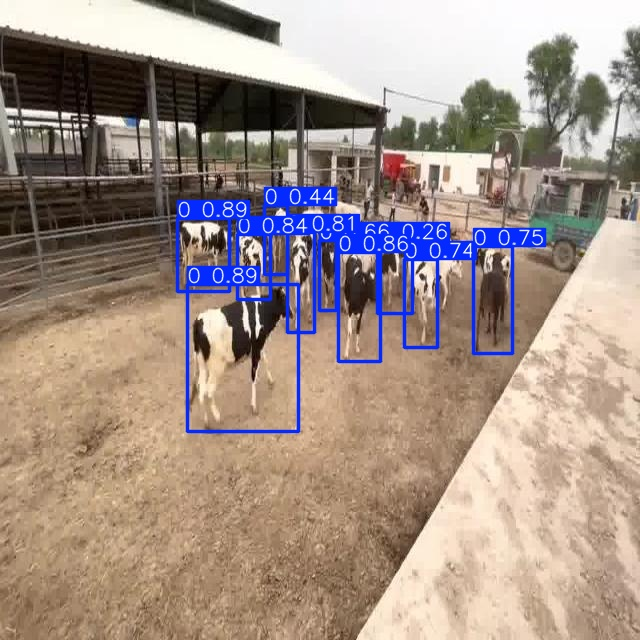


Making prediction on: /content/split_dataset/test/images/vaca63_jpg.rf.919822d7cf5a88b799670931af5de57b.jpg

image 1/1 /content/split_dataset/test/images/vaca63_jpg.rf.919822d7cf5a88b799670931af5de57b.jpg: 640x640 1 10, 28.1ms
Speed: 4.7ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions15

Displaying predicted image:


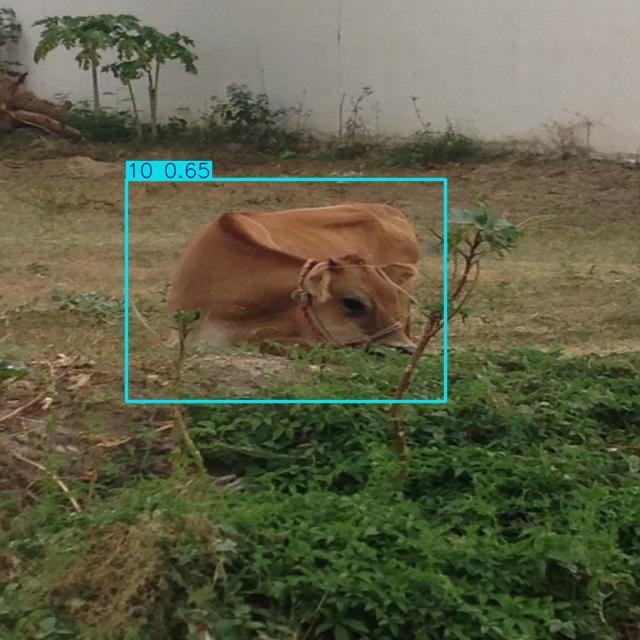


Making prediction on: /content/split_dataset/test/images/Ayrshirecattle22_c_jpg.rf.72fd618edee5e5c95e33b9fc570f8fd5.jpg

image 1/1 /content/split_dataset/test/images/Ayrshirecattle22_c_jpg.rf.72fd618edee5e5c95e33b9fc570f8fd5.jpg: 640x640 1 10, 1 2, 44.1ms
Speed: 2.1ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions16

Displaying predicted image:


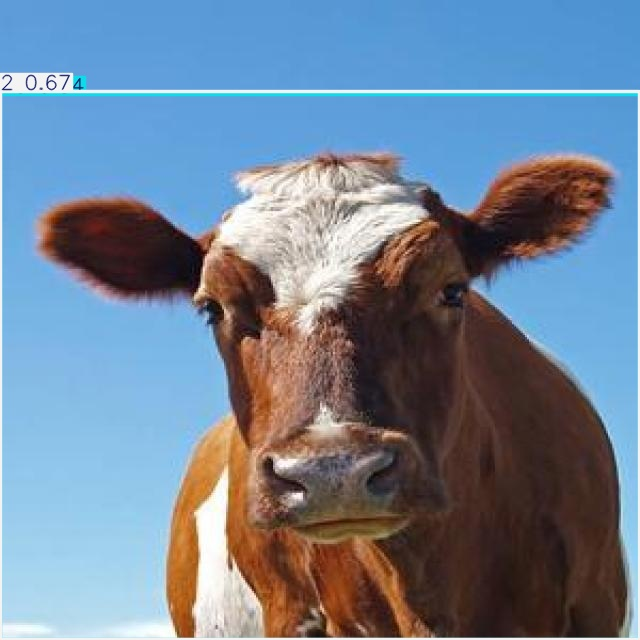


Making prediction on: /content/split_dataset/test/images/maxresdefault-6-_jpg.rf.bc55d33da4ec75794bddc6fa2c3eafce.jpg

image 1/1 /content/split_dataset/test/images/maxresdefault-6-_jpg.rf.bc55d33da4ec75794bddc6fa2c3eafce.jpg: 640x640 2 0s, 27.0ms
Speed: 2.5ms preprocess, 27.0ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions17

Displaying predicted image:


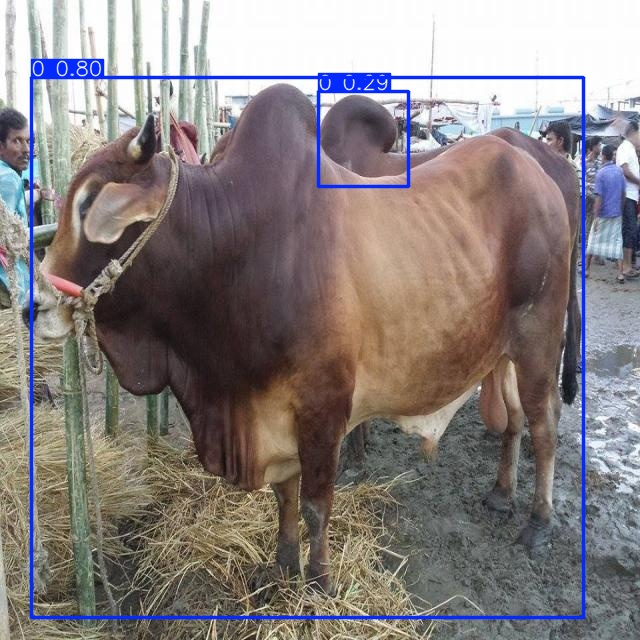


Making prediction on: /content/split_dataset/test/images/HolsteinFriesiancattle140_jpg.rf.68a7dadbad259b4faa200cbc6363696f.jpg

image 1/1 /content/split_dataset/test/images/HolsteinFriesiancattle140_jpg.rf.68a7dadbad259b4faa200cbc6363696f.jpg: 640x640 1 0, 28.8ms
Speed: 2.0ms preprocess, 28.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions18

Displaying predicted image:


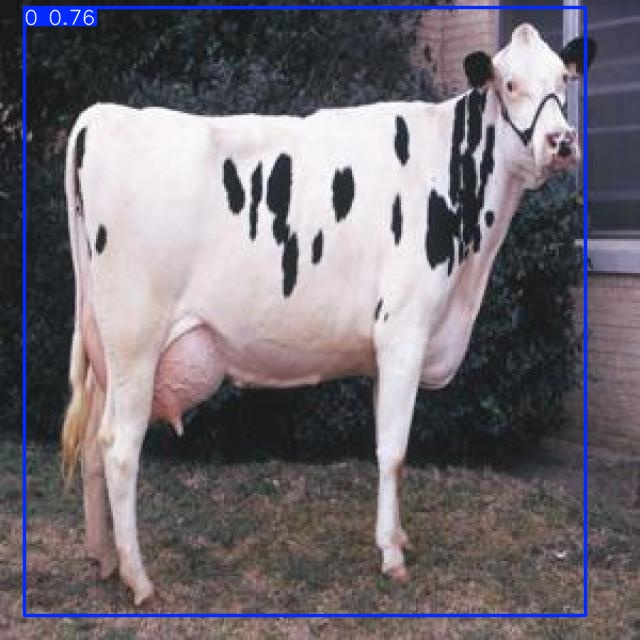

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os
import random

# Define the path to your trained YOLOv8s model weights
train_results_dir = '/content/runs/detect/train5' # <<<< Adjust this path if needed based on your YOLOv8s training output
best_model_path = os.path.join(train_results_dir, 'weights', 'best.pt')

# Load the trained YOLOv8s model
try:
    model_yolov8s = YOLO(best_model_path)
except FileNotFoundError:
    print(f"Error: Trained YOLOv8s model weights not found at {best_model_path}")
    print("Please ensure the path is correct and the YOLOv8s training was successful.")
    model_yolov8s = None

if model_yolov8s:
    # Define the path to the test images directory
    test_images_dir = '/content/split_dataset/test/images'

    # Get a list of all image files in the test directory
    test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if test_image_files:
        # Select 5 random images from the test set
        num_images_to_predict = 7
        images_to_predict_filenames = random.sample(test_image_files, min(num_images_to_predict, len(test_image_files)))

        # Define prediction output directory
        predict_output_dir = os.path.join('runs/predict', 'yolov8s_predictions')
        os.makedirs(predict_output_dir, exist_ok=True) # Ensure output directory exists

        for image_to_predict_filename in images_to_predict_filenames:
            image_to_predict_path = os.path.join(test_images_dir, image_to_predict_filename)

            print(f"\nMaking prediction on: {image_to_predict_path}")

            # Run inference on the image and save the results using the YOLOv8s model
            results = model_yolov8s.predict(
                source=image_to_predict_path,
                save=True,  # Save predicted image with bounding boxes
                save_conf=True, # Save confidence scores
                save_txt=False, # Don't save prediction in txt format
                classes=None, # Predict all classes in the model
                conf=0.25, # Confidence threshold
                iou=0.45, # IoU threshold for NMS
                project='runs/predict', # Directory to save results
                name='yolov8s_predictions' # Subdirectory within project
            )

            
            actual_save_dir = results[0].save_dir # results is a list of Results objects, take the first one

            # Construct the path to the saved image using the actual save directory
            predicted_image_path_display = os.path.join(actual_save_dir, image_to_predict_filename)


            if os.path.exists(predicted_image_path_display):
                print("\nDisplaying predicted image:")
                display(Image(filename=predicted_image_path_display))
            else:
                print(f"Predicted image not found at {predicted_image_path_display}")

    else:
        print(f"No images found in the test directory: {test_images_dir}")
else:
    print("YOLOv8s model not loaded. Cannot make predictions.")

# Yolov8l

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8s model
model = YOLO('yolov8l.pt')

# Define the path to your updated data.yaml file
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Train the model with adjusted hyperparameters and refined augmented data
# Adjusting 'cls' (classification loss gain) and 'lrf' (learning rate factor)
# Note: This is an indirect way to address class imbalance compared to explicit class weights.
# Increasing 'cls' gives more importance to classification loss.
# Adjusting 'lrf' can help stabilize training with potentially increased classification sensitivity.
results = model.train(
    data=data_yaml_path,
    epochs=15, # Increased epochs
    imgsz=640,
    batch=16,
    cls=1.0,  # Increase classification loss gain (default is 0.5)
    lrf=0.005 # Decrease learning rate factor slightly (default is 0.01)
)

print("Model training complete with adjusted hyperparameters and refined data augmentation.")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/archive (11)/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

In [ ]:
from ultralytics import YOLO
import os

# Define the path to your updated data.yaml file (should be the same as used for training)
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Define the path to the trained model weights
# Assuming the latest training run directory is 'train4' based on the previous output
train_results_dir = '/content/runs/detect/train6' # <<<< Adjust this path if needed based on your training output
best_model_path = os.path.join(train_results_dir, 'weights', 'best.pt')

# Load the trained model
try:
    model = YOLO(best_model_path)
except FileNotFoundError:
    print(f"Error: Trained model weights not found at {best_model_path}")
    print("Please ensure the path is correct and the training was successful.")
    model = None

if model:
    # Evaluate the loaded model on the test set
    metrics_test = model.val(data=data_yaml_path, split='test')
    print(metrics_test)

    print("Model evaluation on the test set complete.")
else:
    print("Model not loaded. Cannot perform evaluation.")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,612,005 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.3±9.7 MB/s, size: 64.8 KB)
val: Scanning /content/split_dataset/test/labels.cache... 175 images, 0 backgrounds, 59 corrupt: 100% ━━━━━━━━━━━━ 175/175 195.0Kit/s 0.0s
val: /content/split_dataset/test/images/-OWS_mp4-203_jpg.rf.237d66202ebd25127286a2bb941c4d7f.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/-OWS_mp4-423_jpg.rf.5c549f7b840391ab26b6d03a29eee193.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/Ayrshirecattle0_jpg.rf.109b38b256521bd26ac1135b282bc99e.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
va

## Model Prediction

Using the trained YOLOv8l models to make predictions on new, unseen images from the test set and visualizing the results.


Making prediction on: /content/split_dataset/test/images/hf03-48_jpeg_jpg.rf.07d57256914ad679dab9598a86bbef4a.jpg

image 1/1 /content/split_dataset/test/images/hf03-48_jpeg_jpg.rf.07d57256914ad679dab9598a86bbef4a.jpg: 640x640 9 0s, 56.1ms
Speed: 1.7ms preprocess, 56.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions26

Displaying predicted image:


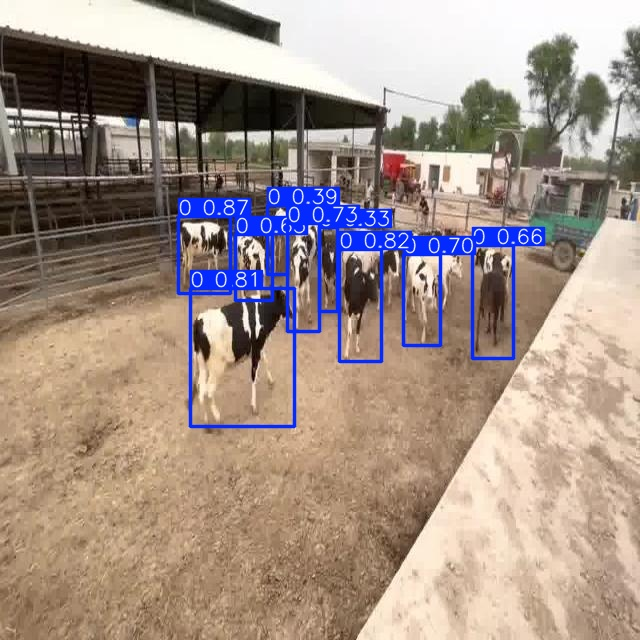


Making prediction on: /content/split_dataset/test/images/vaca63_jpg.rf.919822d7cf5a88b799670931af5de57b.jpg

image 1/1 /content/split_dataset/test/images/vaca63_jpg.rf.919822d7cf5a88b799670931af5de57b.jpg: 640x640 1 10, 49.3ms
Speed: 2.3ms preprocess, 49.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions27

Displaying predicted image:


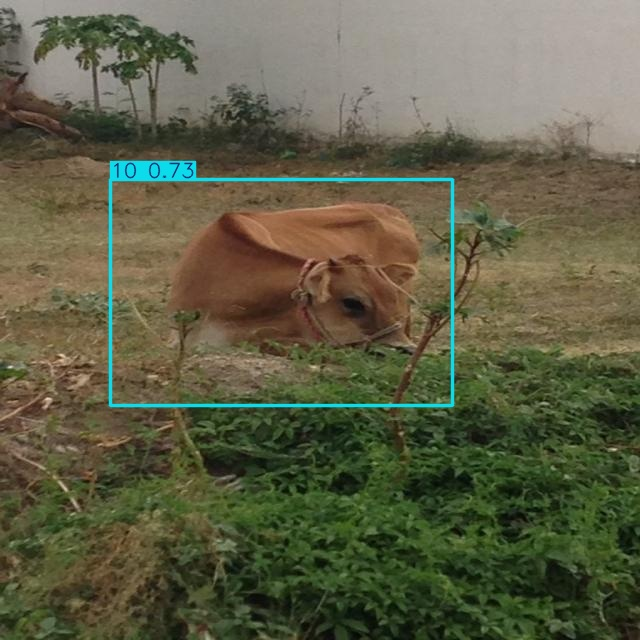


Making prediction on: /content/split_dataset/test/images/Ayrshirecattle22_c_jpg.rf.72fd618edee5e5c95e33b9fc570f8fd5.jpg

image 1/1 /content/split_dataset/test/images/Ayrshirecattle22_c_jpg.rf.72fd618edee5e5c95e33b9fc570f8fd5.jpg: 640x640 1 10, 1 2, 49.4ms
Speed: 2.5ms preprocess, 49.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions28

Displaying predicted image:


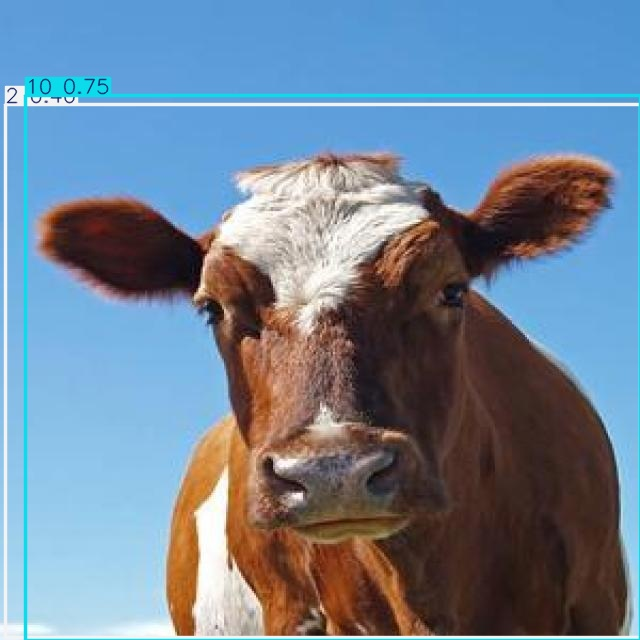


Making prediction on: /content/split_dataset/test/images/maxresdefault-6-_jpg.rf.bc55d33da4ec75794bddc6fa2c3eafce.jpg

image 1/1 /content/split_dataset/test/images/maxresdefault-6-_jpg.rf.bc55d33da4ec75794bddc6fa2c3eafce.jpg: 640x640 1 0, 36.2ms
Speed: 2.3ms preprocess, 36.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions29

Displaying predicted image:


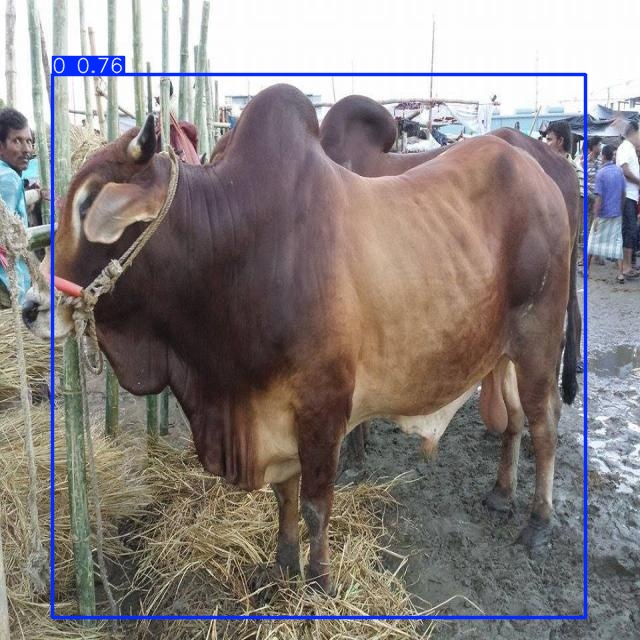


Making prediction on: /content/split_dataset/test/images/HolsteinFriesiancattle140_jpg.rf.68a7dadbad259b4faa200cbc6363696f.jpg

image 1/1 /content/split_dataset/test/images/HolsteinFriesiancattle140_jpg.rf.68a7dadbad259b4faa200cbc6363696f.jpg: 640x640 1 0, 35.0ms
Speed: 2.4ms preprocess, 35.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions30

Displaying predicted image:


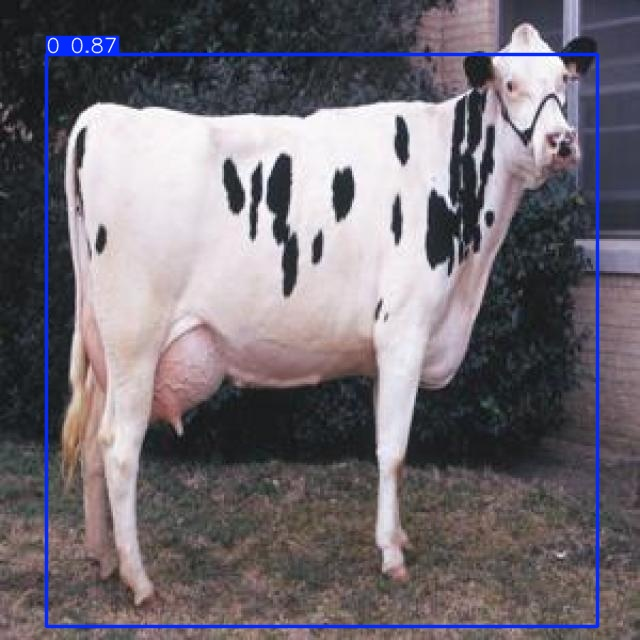


Making prediction on: /content/split_dataset/test/images/vaca220_jpg.rf.7eb7157c5d0f0aac9eb36de9dbc6c2ed.jpg

image 1/1 /content/split_dataset/test/images/vaca220_jpg.rf.7eb7157c5d0f0aac9eb36de9dbc6c2ed.jpg: 640x640 1 10, 34.5ms
Speed: 2.5ms preprocess, 34.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s_predictions31

Displaying predicted image:


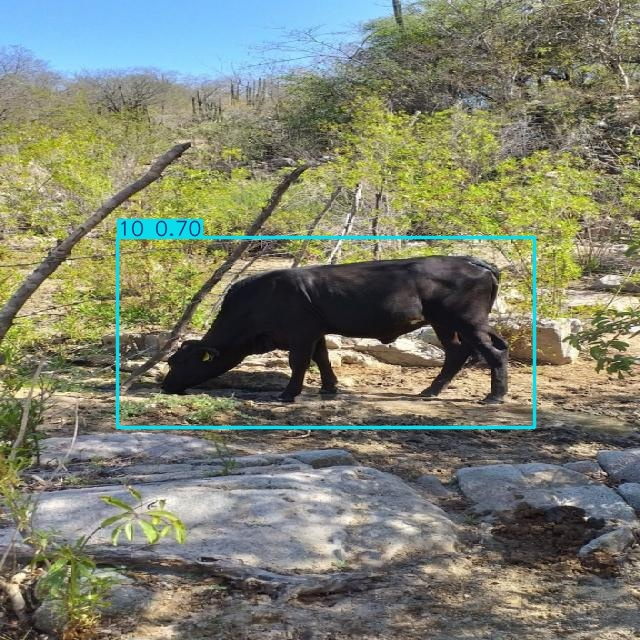

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os
import random

# Define the path to your trained YOLOv8s model weights
# Assuming the latest training run directory for YOLOv8s was 'train4' based on previous output
train_results_dir = '/content/runs/detect/train6' # <<<< Adjust this path if needed based on your YOLOv8s training output
best_model_path = os.path.join(train_results_dir, 'weights', 'best.pt')

# Load the trained YOLOv8s model
try:
    model_yolov8s = YOLO(best_model_path)
except FileNotFoundError:
    print(f"Error: Trained YOLOv8s model weights not found at {best_model_path}")
    print("Please ensure the path is correct and the YOLOv8s training was successful.")
    model_yolov8s = None

if model_yolov8s:
    # Define the path to the test images directory
    test_images_dir = '/content/split_dataset/test/images'

    # Get a list of all image files in the test directory
    test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if test_image_files:
        # Select 5 random images from the test set
        num_images_to_predict = 6
        images_to_predict_filenames = random.sample(test_image_files, min(num_images_to_predict, len(test_image_files)))

        # Define prediction output directory
        predict_output_dir = os.path.join('runs/predict', 'yolov8s_predictions')
        os.makedirs(predict_output_dir, exist_ok=True) # Ensure output directory exists

        for image_to_predict_filename in images_to_predict_filenames:
            image_to_predict_path = os.path.join(test_images_dir, image_to_predict_filename)

            print(f"\nMaking prediction on: {image_to_predict_path}")

            # Run inference on the image and save the results using the YOLOv8s model
            results = model_yolov8s.predict(
                source=image_to_predict_path,
                save=True,  # Save predicted image with bounding boxes
                save_conf=True, # Save confidence scores
                save_txt=False, # Don't save prediction in txt format
                classes=None, # Predict all classes in the model
                conf=0.25, # Confidence threshold
                iou=0.45, # IoU threshold for NMS
                project='runs/predict', # Directory to save results
                name='yolov8s_predictions' # Subdirectory within project
            )

            
            actual_save_dir = results[0].save_dir # results is a list of Results objects, take the first one

            # Construct the path to the saved image using the actual save directory
            predicted_image_path_display = os.path.join(actual_save_dir, image_to_predict_filename)


            if os.path.exists(predicted_image_path_display):
                print("\nDisplaying predicted image:")
                display(Image(filename=predicted_image_path_display))
            else:
                print(f"Predicted image not found at {predicted_image_path_display}")

    else:
        print(f"No images found in the test directory: {test_images_dir}")
else:
    print("YOLOv8s model not loaded. Cannot make predictions.")

## Compare model performance


Presenting the collected metrics in a clear format (e.g., a table or chart) to easily compare the performance of each YOLOv8 variant on the validation and test sets.


Evaluation Metrics for YOLOv8 Variants:


model  mAP_0.5  mAP_0.5:0.95
0  YOLOv8n    0.006         0.003
1  YOLOv8s    0.009         0.004
2  YOLOv8m    0.008         0.003
3  YOLOv8l    0.008         0.003

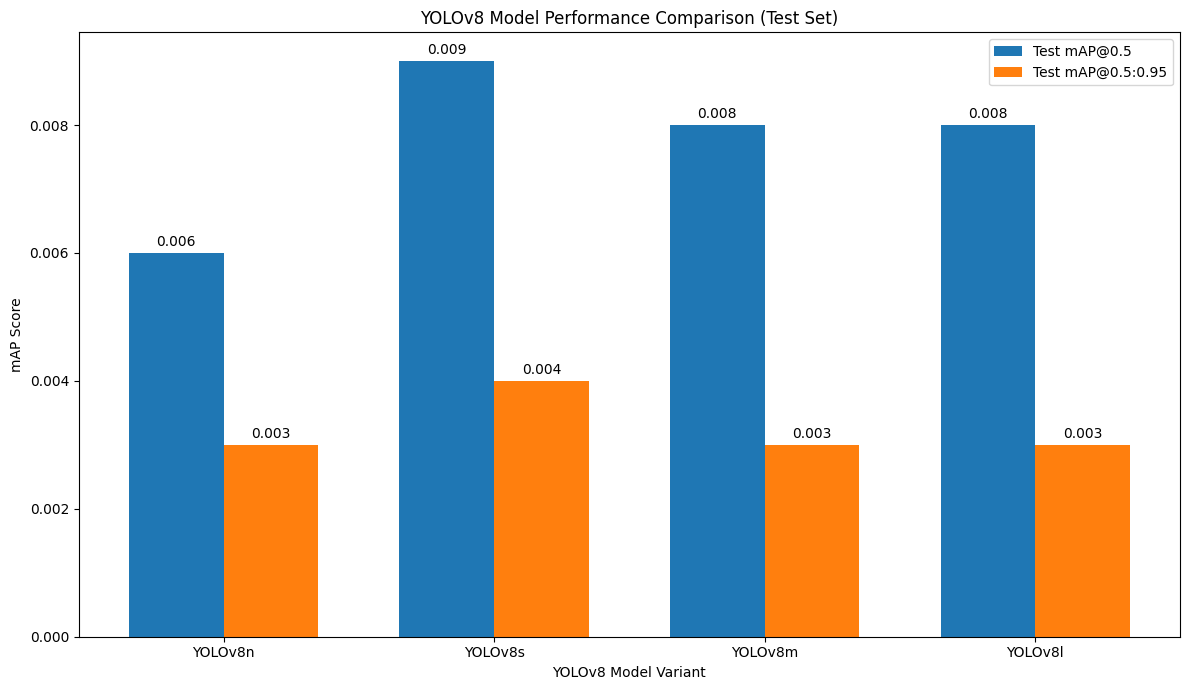

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Manually extracted metrics from the output of the evaluation cells:
# YOLOv8n (from cell 013w4gaj_m3b): mAP50-95: 0.003, mAP50: 0.006
# YOLOv8s (from cell LH1v4txBGAfx): mAP50-95: 0.004, mAP50: 0.009
# YOLOv8m (from cell 6KZn42ZWO9YN): mAP50-95: 0.003, mAP50: 0.008
# YOLOv8l (from cell uXJwHAoZba7s): mAP50-95: 0.003, mAP50: 0.008

# Create a list of dictionaries with the extracted metrics for plotting
all_models_metrics_for_plot = [
    {
        'model': 'YOLOv8n',
        'mAP_0.5': 0.006,
        'mAP_0.5:0.95': 0.003
    },
    {
        'model': 'YOLOv8s',
        'mAP_0.5': 0.009,
        'mAP_0.5:0.95': 0.004
    },
    {
        'model': 'YOLOv8m',
        'mAP_0.5': 0.008,
        'mAP_0.5:0.95': 0.003
    },
    {
        'model': 'YOLOv8l',
        'mAP_0.5': 0.008,
        'mAP_0.5:0.95': 0.003
    }
]


# Convert to a pandas DataFrame
df_metrics = pd.DataFrame(all_models_metrics_for_plot)

# Display the DataFrame
print("Evaluation Metrics for YOLOv8 Variants:")
display(df_metrics)

# Prepare data for plotting
models = df_metrics['model']
test_mAP_0_5 = df_metrics['mAP_0.5']
test_mAP_0_5_0_95 = df_metrics['mAP_0.5:0.95']


x = np.arange(len(models)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

rects1 = ax.bar(x - width/2, test_mAP_0_5, width, label='Test mAP@0.5')
rects2 = ax.bar(x + width/2, test_mAP_0_5_0_95, width, label='Test mAP@0.5:0.95')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('YOLOv8 Model Variant')
ax.set_ylabel('mAP Score')
ax.set_title('YOLOv8 Model Performance Comparison (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add value labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


fig.tight_layout()
plt.show()

## Identify the best model

Identify the best performing model variant based on the evaluated metrics.


In [ ]:
# Analyze the DataFrame to identify the best performing model on the test set
best_model_mAP_0_5 = df_metrics.loc[df_metrics['mAP_0.5'].idxmax()]
best_model_mAP_0_5_0_95 = df_metrics.loc[df_metrics['mAP_0.5:0.95'].idxmax()]

print("Best model based on test mAP@0.5:")
display(best_model_mAP_0_5)

print("\nBest model based on test mAP@0.5:0.95:")
display(best_model_mAP_0_5_0_95)

# Conclude the best performing model overall based on test set performance
# Since both metrics point to the same model in this case, we can state the overall best model.
if best_model_mAP_0_5['model'] == best_model_mAP_0_5_0_95['model']:
    print(f"\nBased on both test mAP@0.5 and test mAP@0.5:0.95, the best performing model variant is: {best_model_mAP_0_5['model']}")
else:
    print("\nThe best performing model based on test mAP@0.5 and test mAP@0.5:0.95 are different.")
    print(f"Best based on mAP@0.5: {best_model_mAP_0_5['model']}")
    print(f"Best based on mAP@0.5:0.5: {best_model_mAP_0_5_0_95['model']}")

Best model based on test mAP@0.5:


model           YOLOv8s
mAP_0.5           0.009
mAP_0.5:0.95      0.004
Name: 1, dtype: object


Best model based on test mAP@0.5:0.95:


model           YOLOv8s
mAP_0.5           0.009
mAP_0.5:0.95      0.004
Name: 1, dtype: object


Based on both test mAP@0.5 and test mAP@0.5:0.95, the best performing model variant is: YOLOv8s


## 6. Exploring Other YOLO Versions
Attempts were made to train and evaluate other popular YOLO versions ,like YOLOv5 , YOLOv10

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv5s model
# Note: Ultralytics library supports YOLOv5 as well
model_yolov5 = YOLO('yolov5n.pt')

# Define the path to your updated data.yaml file
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Train the YOLOv5 model
# Using similar hyperparameters as the YOLOv8 training for comparison
results_yolov5 = model_yolov5.train(
    data=data_yaml_path,
    epochs=15, # Consistent with previous training
    imgsz=640,
    batch=16,
    cls=1.0,  # Consistent with previous training
    lrf=0.005 # Consistent with previous training
)

print("YOLOv5s model training complete.")

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/archive (11)/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=

In [ ]:
from ultralytics import YOLO
import os

# Define the path to your updated data.yaml file
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Define the path to the trained YOLOv5s model weights
# Assuming the latest training run directory for YOLOv5s is 'train7' based on the previous output
train_results_dir_yolov5 = '/content/runs/detect/train8' # <<<< Adjust this path if needed
best_model_path_yolov5 = os.path.join(train_results_dir_yolov5, 'weights', 'best.pt')

# Load the trained YOLOv5s model
try:
    model_yolov5_trained = YOLO(best_model_path_yolov5)
except FileNotFoundError:
    print(f"Error: Trained YOLOv5s model weights not found at {best_model_path_yolov5}")
    print("Please ensure the path is correct and the training was successful.")
    model_yolov5_trained = None

if model_yolov5_trained:
    # Evaluate the loaded YOLOv5s model on the test set
    metrics_test_yolov5 = model_yolov5_trained.val(data=data_yaml_path, split='test')
    print(metrics_test_yolov5)

    print("YOLOv5s Model evaluation on the test set complete.")
else:
    print("YOLOv5s model not loaded. Cannot perform evaluation.")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5n summary (fused): 84 layers, 2,504,309 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 23.8±12.3 MB/s, size: 64.8 KB)
val: Scanning /content/split_dataset/test/labels.cache... 175 images, 0 backgrounds, 59 corrupt: 100% ━━━━━━━━━━━━ 175/175 44.2Kit/s 0.0s
val: /content/split_dataset/test/images/-OWS_mp4-203_jpg.rf.237d66202ebd25127286a2bb941c4d7f.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/-OWS_mp4-423_jpg.rf.5c549f7b840391ab26b6d03a29eee193.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/Ayrshirecattle0_jpg.rf.109b38b256521bd26ac1135b282bc99e.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 7. Possible class labels are 0-6
val:


Making prediction on: /content/split_dataset/test/images/HolsteinFriesiancattle99_jpg.rf.3178b009749596686c737ece0f50b9e2.jpg

image 1/1 /content/split_dataset/test/images/HolsteinFriesiancattle99_jpg.rf.3178b009749596686c737ece0f50b9e2.jpg: 640x640 1 0, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov5n_predictions

Displaying predicted image:


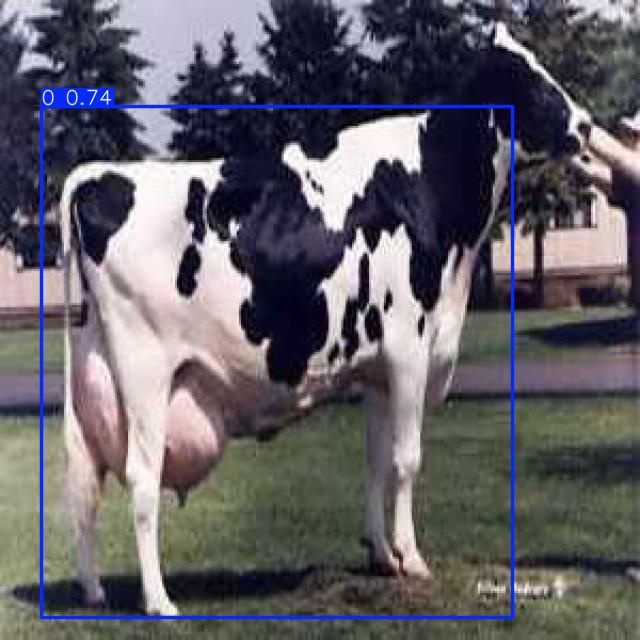


Making prediction on: /content/split_dataset/test/images/HolsteinFriesiancattle15_jpg.rf.301e052c1f293273862a69d695aa8e5e.jpg

image 1/1 /content/split_dataset/test/images/HolsteinFriesiancattle15_jpg.rf.301e052c1f293273862a69d695aa8e5e.jpg: 640x640 1 0, 13.4ms
Speed: 3.6ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov5n_predictions2

Displaying predicted image:


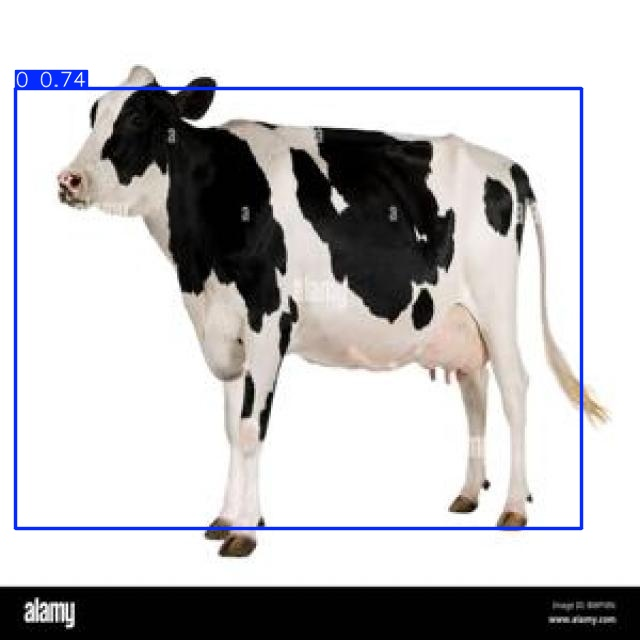


Making prediction on: /content/split_dataset/test/images/vaca102_jpg.rf.6a299aeb48afadf7bb38cf0870d64c0b.jpg

image 1/1 /content/split_dataset/test/images/vaca102_jpg.rf.6a299aeb48afadf7bb38cf0870d64c0b.jpg: 640x640 1 10, 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov5n_predictions3

Displaying predicted image:


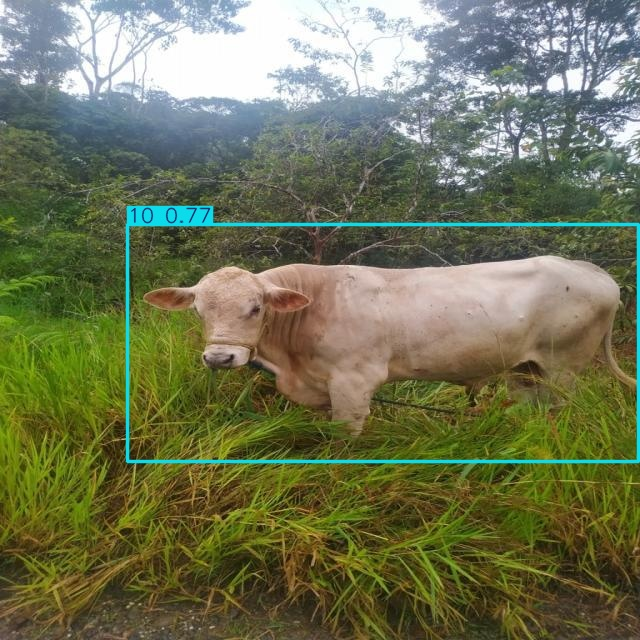


Making prediction on: /content/split_dataset/test/images/vaca208_jpg.rf.4caef700c884a9072d53fe663b0cda37.jpg

image 1/1 /content/split_dataset/test/images/vaca208_jpg.rf.4caef700c884a9072d53fe663b0cda37.jpg: 640x640 1 10, 16.1ms
Speed: 3.9ms preprocess, 16.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov5n_predictions4

Displaying predicted image:


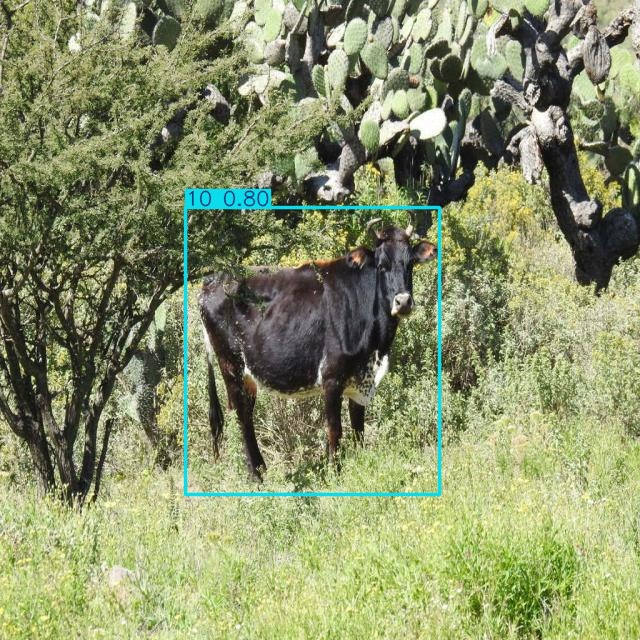


Making prediction on: /content/split_dataset/test/images/vaca49_jpg.rf.d19816a670e21dd0ce4b73c2031e65ac.jpg

image 1/1 /content/split_dataset/test/images/vaca49_jpg.rf.d19816a670e21dd0ce4b73c2031e65ac.jpg: 640x640 1 10, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov5n_predictions5

Displaying predicted image:


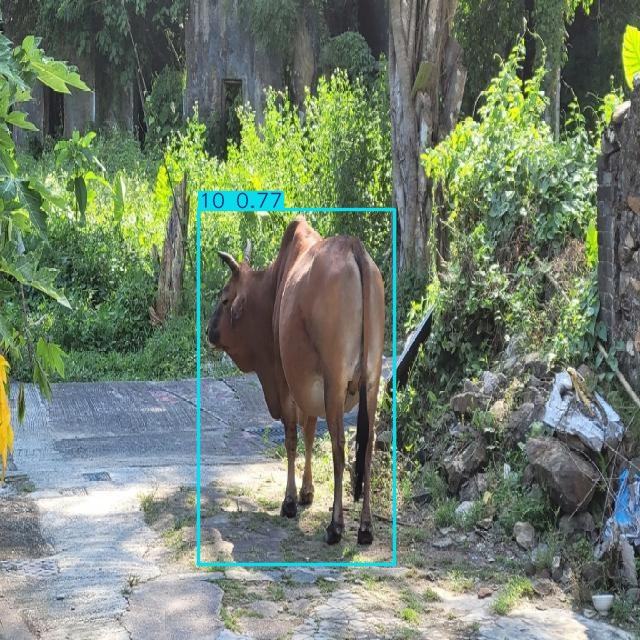

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os
import random

# Define the path to your trained YOLOv5n model weights
# Assuming the latest training run directory for YOLOv5n was 'train8' based on previous output
train_results_dir_yolov5 = '/content/runs/detect/train8' # <<<< Adjust this path if needed
best_model_path_yolov5 = os.path.join(train_results_dir_yolov5, 'weights', 'best.pt')

# Load the trained YOLOv5n model
try:
    model_yolov5_trained = YOLO(best_model_path_yolov5)
except FileNotFoundError:
    print(f"Error: Trained YOLOv5n model weights not found at {best_model_path_yolov5}")
    print("Please ensure the path is correct and the training was successful.")
    model_yolov5_trained = None

if model_yolov5_trained:
    # Define the path to the test images directory
    test_images_dir = '/content/split_dataset/test/images'

    # Get a list of all image files in the test directory
    test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if test_image_files:
        # Select a few random images from the test set to predict on
        num_images_to_predict = 5 # You can change this number
        images_to_predict_filenames = random.sample(test_image_files, min(num_images_to_predict, len(test_image_files)))

        for image_to_predict_filename in images_to_predict_filenames:
            image_to_predict_path = os.path.join(test_images_dir, image_to_predict_filename)

            print(f"\nMaking prediction on: {image_to_predict_path}")

            # Run inference on the image and save the results using the YOLOv5n model
            results = model_yolov5_trained.predict(
                source=image_to_predict_path,
                save=True,  # Save predicted image with bounding boxes
                save_conf=True, # Save confidence scores
                save_txt=False, # Don't save prediction in txt format
                classes=None, # Predict all classes in the model
                conf=0.25, # Confidence threshold
                iou=0.45, # IoU threshold for NMS
                project='runs/predict', # Directory to save results
                name='yolov5n_predictions' # Subdirectory within project for YOLOv5n predictions
            )

            # Get the actual directory where the results were saved from the results object
            # The predicted image will be saved directly in this directory
            actual_save_dir = results[0].save_dir # results is a list of Results objects, take the first one

            # Construct the path to the saved image using the actual save directory
            predicted_image_path_display = os.path.join(actual_save_dir, image_to_predict_filename)


            if os.path.exists(predicted_image_path_display):
                print("\nDisplaying predicted image:")
                display(Image(filename=predicted_image_path_display))
            else:
                print(f"Predicted image not found at {predicted_image_path_display}")

    else:
        print(f"No images found in the test directory: {test_images_dir}")
else:
    print("YOLOv5n model not loaded. Cannot make predictions.")

# `YOLOv10n`

In [ ]:
from ultralytics import YOLO


try:
    model_yolov10 = YOLO('yolov10n.pt')
except Exception as e:
    print(f"Could not load yolov10n.pt directly: {e}")
    print("Trying to load by model name 'yolov10n'...")
    try:
        model_yolov10 = YOLO('yolov10n') # Try loading by model name
    except Exception as e_name:
        print(f"Could not load yolov10n by name: {e_name}")
        print("Please ensure you have a library version that supports YOLOv10 and the weights are accessible.")
        model_yolov10 = None # Set model to None if loading fails


# Define the path to your updated data.yaml file
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Train the YOLOv10 model if it was loaded successfully
if model_yolov10:
    print("YOLOv10 model loaded successfully. Proceeding with training.")
    # Using similar hyperparameters as the previous training runs for consistency
    results_yolov10 = model_yolov10.train(
        data=data_yaml_path,
        epochs=15, # Consistent with previous training
        imgsz=640,
        batch=16,
        cls=1.0,  # Consistent with previous training
        lrf=0.005 # Consistent with previous training
    )

    print("YOLOv10n model training complete.")
else:
    print("YOLOv10 model could not be loaded. Skipping training.")

YOLOv10 model loaded successfully. Proceeding with training.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/archive (11)/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, opt

In [ ]:
from ultralytics import YOLO
import os

# Define the path to your updated data.yaml file (should be the same as used for training)
data_yaml_path = '/content/drive/MyDrive/archive (11)/data.yaml'

# Define the path to the trained YOLOv10n model weights

train_results_dir_yolov10 = '/content/runs/detect/train2' # <<<< Adjust this path if needed based on your YOLOv10n training output
best_model_path_yolov10 = os.path.join(train_results_dir_yolov10, 'weights', 'best.pt')

# Load the trained YOLOv10n model
try:
    model_yolov10_trained = YOLO(best_model_path_yolov10)
except FileNotFoundError:
    print(f"Error: Trained YOLOv10n model weights not found at {best_model_path_yolov10}")
    print("Please ensure the path is correct and the training was successful.")
    model_yolov10_trained = None

if model_yolov10_trained:
    # Evaluate the loaded YOLOv10n model on the test set
    print("Evaluating YOLOv10n model on the test set...")
    metrics_test_yolov10 = model_yolov10_trained.val(data=data_yaml_path, split='test')
    print(metrics_test_yolov10)

    print("YOLOv10n Model evaluation on the test set complete.")
else:
    print("YOLOv10n model not loaded. Cannot perform evaluation.")

Evaluating YOLOv10n model on the test set...
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,533 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 18.9±8.7 MB/s, size: 71.8 KB)
val: Scanning /content/split_dataset/test/labels... 175 images, 0 backgrounds, 59 corrupt: 100% ━━━━━━━━━━━━ 175/175 592.1it/s 0.3s
val: /content/split_dataset/test/images/-OWS_mp4-203_jpg.rf.237d66202ebd25127286a2bb941c4d7f.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/-OWS_mp4-423_jpg.rf.5c549f7b840391ab26b6d03a29eee193.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 7. Possible class labels are 0-6
val: /content/split_dataset/test/images/Ayrshirecattle0_jpg.rf.109b38b256521bd26ac1135b282bc99e.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class cou


Making prediction on: /content/split_dataset/test/images/Ayrshirecattle22_c_jpg.rf.72fd618edee5e5c95e33b9fc570f8fd5.jpg

image 1/1 /content/split_dataset/test/images/Ayrshirecattle22_c_jpg.rf.72fd618edee5e5c95e33b9fc570f8fd5.jpg: 640x640 1 class_4, 7.7ms
Speed: 1.5ms preprocess, 7.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov10n_predictions12

Displaying predicted image:


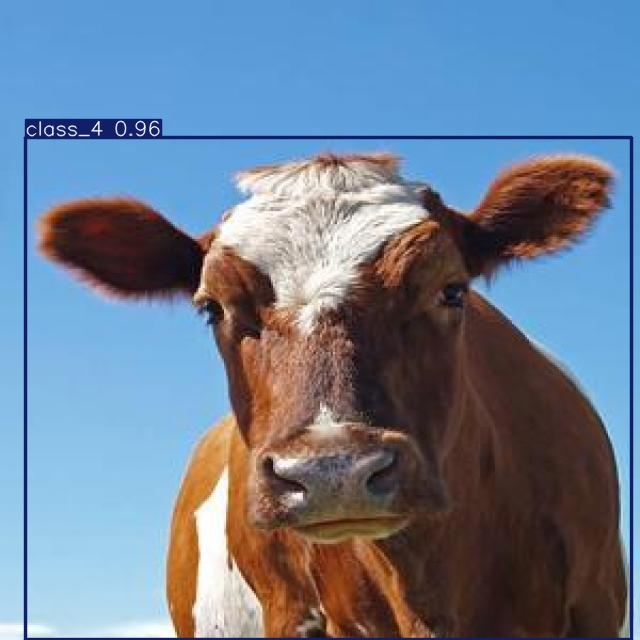


Making prediction on: /content/split_dataset/test/images/maxresdefault-6-_jpg.rf.bc55d33da4ec75794bddc6fa2c3eafce.jpg

image 1/1 /content/split_dataset/test/images/maxresdefault-6-_jpg.rf.bc55d33da4ec75794bddc6fa2c3eafce.jpg: 640x640 1 class_0, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov10n_predictions13

Displaying predicted image:


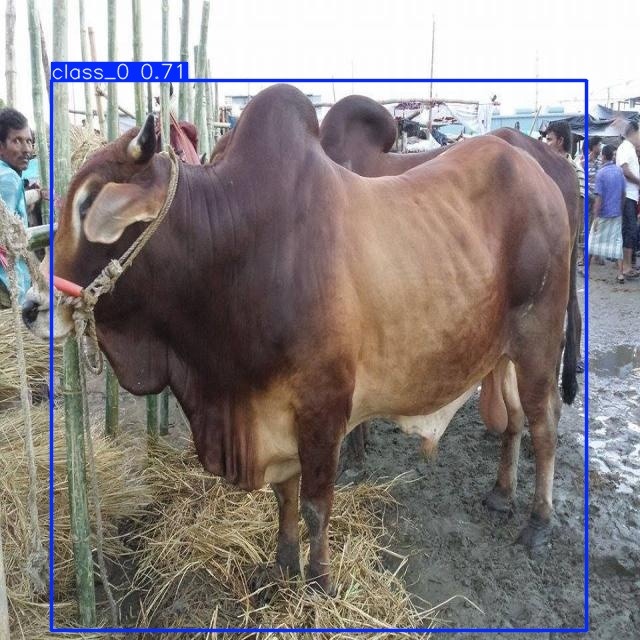


Making prediction on: /content/split_dataset/test/images/HolsteinFriesiancattle140_jpg.rf.68a7dadbad259b4faa200cbc6363696f.jpg

image 1/1 /content/split_dataset/test/images/HolsteinFriesiancattle140_jpg.rf.68a7dadbad259b4faa200cbc6363696f.jpg: 640x640 2 class_4s, 1 class_6, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov10n_predictions14

Displaying predicted image:


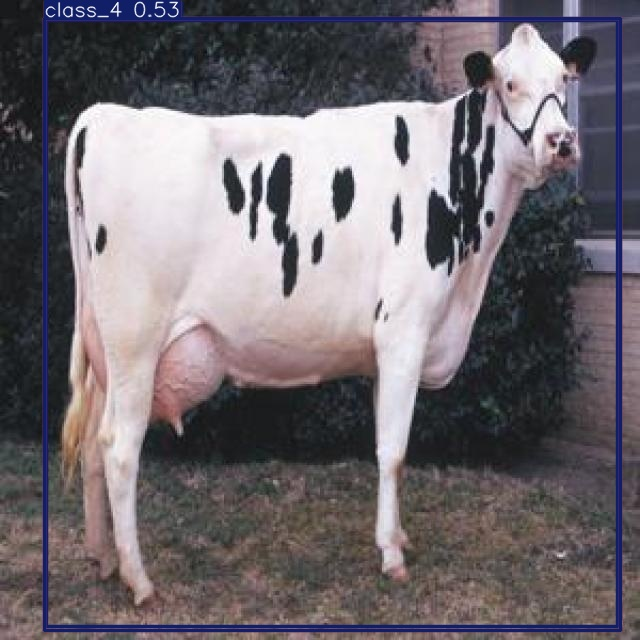


Making prediction on: /content/split_dataset/test/images/vaca220_jpg.rf.7eb7157c5d0f0aac9eb36de9dbc6c2ed.jpg

image 1/1 /content/split_dataset/test/images/vaca220_jpg.rf.7eb7157c5d0f0aac9eb36de9dbc6c2ed.jpg: 640x640 1 class_1, 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov10n_predictions15

Displaying predicted image:


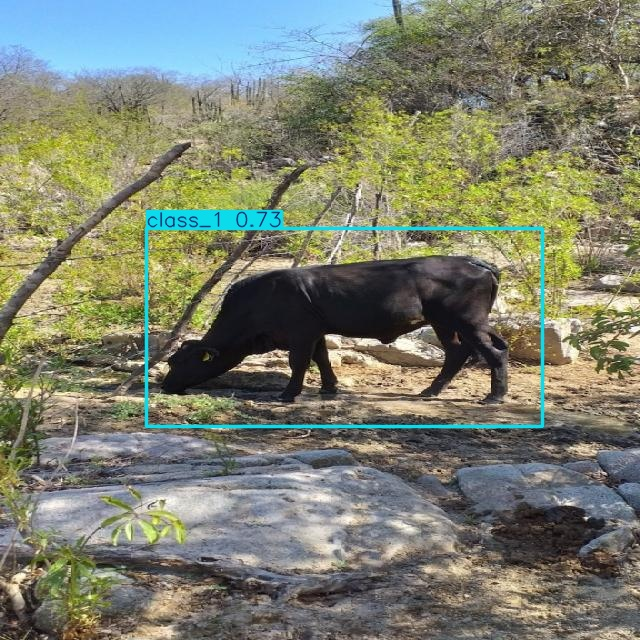


Making prediction on: /content/split_dataset/test/images/Ayrshirecattle75_c_jpg.rf.f94bc89a907577a06dffa4cc9c7f9a12.jpg

image 1/1 /content/split_dataset/test/images/Ayrshirecattle75_c_jpg.rf.f94bc89a907577a06dffa4cc9c7f9a12.jpg: 640x640 5 class_4s, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov10n_predictions16

Displaying predicted image:


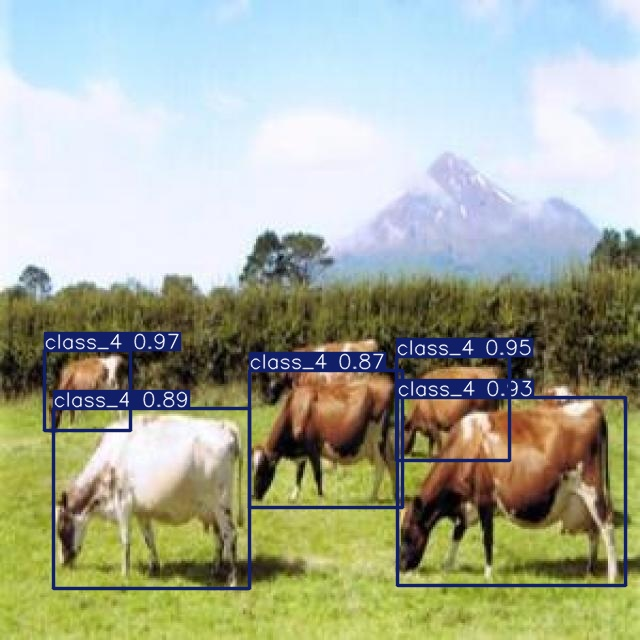

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os
import random

# Define the path to your trained YOLOv10n model weights
# Assuming the latest training run directory for YOLOv10n was 'train2' based on previous output
train_results_dir_yolov10 = '/content/runs/detect/train2' # <<<< Adjust this path if needed
best_model_path_yolov10 = os.path.join(train_results_dir_yolov10, 'weights', 'best.pt')

# Load the trained YOLOv10n model
try:
    model_yolov10_trained = YOLO(best_model_path_yolov10)
except FileNotFoundError:
    print(f"Error: Trained YOLOv10n model weights not found at {best_model_path_yolov10}")
    print("Please ensure the path is correct and the training was successful.")
    model_yolov10_trained = None

if model_yolov10_trained:
    # Define the path to the test images directory
    test_images_dir = '/content/split_dataset/test/images'

    # Get a list of all image files in the test directory
    test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if test_image_files:
        # Select a few random images from the test set to predict on
        num_images_to_predict = 5 # You can change this number
        images_to_predict_filenames = random.sample(test_image_files, min(num_images_to_predict, len(test_image_files)))

        # Define prediction output directory
        predict_output_dir = os.path.join('runs/predict', 'yolov10n_predictions')
        os.makedirs(predict_output_dir, exist_ok=True) # Ensure output directory exists

        for image_to_predict_filename in images_to_predict_filenames:
            image_to_predict_path = os.path.join(test_images_dir, image_to_predict_filename)

            print(f"\nMaking prediction on: {image_to_predict_path}")

            # Run inference on the image and save the results using the YOLOv10n model
            results = model_yolov10_trained.predict(
                source=image_to_predict_path,
                save=True,  # Save predicted image with bounding boxes
                save_conf=True, # Save confidence scores
                save_txt=False, # Don't save prediction in txt format
                classes=None, # Predict all classes in the model
                conf=0.25, # Confidence threshold
                iou=0.45, # IoU threshold for NMS
                project='runs/predict', # Directory to save results
                name='yolov10n_predictions' # Subdirectory within project for YOLOv10n predictions
            )

           
            actual_save_dir = results[0].save_dir # results is a list of Results objects, take the first one

            # Construct the path to the saved image using the actual save directory
            predicted_image_path_display = os.path.join(actual_save_dir, image_to_predict_filename)


            if os.path.exists(predicted_image_path_display):
                print("\nDisplaying predicted image:")
                display(Image(filename=predicted_image_path_display))
            else:
                print(f"Predicted image not found at {predicted_image_path_display}")

    else:
        print(f"No images found in the test directory: {test_images_dir}")
else:
    print("YOLOv10n model not loaded. Cannot make predictions.")